<a href="https://colab.research.google.com/github/nbilasals/indonesia_salary_forecast/blob/main/ump_indo_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Regional Salaries (UMR) in Indonesia Using Time Series

This notebook demonstrates the use of the Time Series model for forecasting salary trends in different regions over time. The dataset contains salary information by region and year in Indonesia.

By the end of this notebook, you will:
1. Learn how to prepare time series data.
2. Explore trends and patterns in salary data.
3. Build and evaluate an ARIMA model.

**Key Question:** How can we forecast future salary trends based on historical data?


## Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import files
import os
import shutil
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

## Data Preparation

In this section, we load the salary data, clean it, and prepare it for time series modeling.


### Loading Data

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
shutil.move('kaggle.json', '~/.kaggle/kaggle.json')
!chmod 600 ~/.kaggle/kaggle.json

FileNotFoundError: [Errno 2] No such file or directory: '~/.kaggle/kaggle.json'

In [ ]:
!kaggle datasets download -d linkgish/indonesian-salary-by-region-19972022

Dataset URL: https://www.kaggle.com/datasets/linkgish/indonesian-salary-by-region-19972022
License(s): GPL-2.0
  0% 0.00/5.08k [00:00<?, ?B/s]
100% 5.08k/5.08k [00:00<00:00, 15.1MB/s]


In [ ]:
!unzip indonesian-salary-by-region-19972022.zip

Archive:  indonesian-salary-by-region-19972022.zip
  inflating: Indonesian Salary by Region (1997-2022).csv  


In [ ]:
df = pd.read_csv("Indonesian Salary by Region (1997-2022).csv")
df

,REGION,SALARY,YEAR
0,ACEH,128000,1997
1,SUMATERA UTARA,151000,1997
2,SUMATERA BARAT,119000,1997
3,RIAU,151500,1997
4,JAMBI,119500,1997
...,...,...,...
865,MALUKU,2619312,2022
866,MALUKU UTARA,2862231,2022
867,PAPUA BARAT,3200000,2022
868,PAPUA,3561932,2022


Dataset Overview:
- **Columns**: `REGION`, `YEAR`, `SALARY`
- **Goal**: Analyze salary trends across regions and forecast future salaries.


### Data Understanding

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   REGION  870 non-null    object
 1   SALARY  870 non-null    int64 
 2   YEAR    870 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 20.5+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SALARY,870.0,1.179872e+06,917543.542926,106000.0,421500.0,890387.5,1867582.75,4452724.0
YEAR,870.0,2.009816e+03,7.453930,1997.0,2003.0,2010.0,2016.00,2022.0


In [ ]:
print("Number of rows and columns:")
print(df.shape)

Number of rows and columns:
(870, 3)


In [ ]:
# Data conditions
print("\nNumber of missing values per column:")
print(df.isnull().sum())


Number of missing values per column:
REGION    0
SALARY    0
YEAR      0
dtype: int64


In [ ]:
print("\nNumber of duplicate rows:")
print(df.duplicated().sum())


Number of duplicate rows:
0


In [ ]:
# Description of all features
print("\nDescription of all features:")
for col in df.columns:
    print(f"Feature: {col}")
    print(f" - Data Type: {df[col].dtype}")
    if df[col].dtype == 'object':
        print(f" - Sample Values: {df[col].unique()[:5]}")
    else:
        print(f" - Descriptive Statistics:\n{df[col].describe()}")


Description of all features:
Feature: REGION
 - Data Type: object
 - Sample Values: ['ACEH' 'SUMATERA UTARA' 'SUMATERA BARAT' 'RIAU' 'JAMBI']
Feature: SALARY
 - Data Type: int64
 - Descriptive Statistics:
count    8.700000e+02
mean     1.179872e+06
std      9.175435e+05
min      1.060000e+05
25%      4.215000e+05
50%      8.903875e+05
75%      1.867583e+06
max      4.452724e+06
Name: SALARY, dtype: float64
Feature: YEAR
 - Data Type: int64
 - Descriptive Statistics:
count     870.000000
mean     2009.816092
std         7.453930
min      1997.000000
25%      2003.000000
50%      2010.000000
75%      2016.000000
max      2022.000000
Name: YEAR, dtype: float64


### Data Preparation

#### Case Formatting

In [ ]:
df['REGION'] = df['REGION'].str.title()
df

,REGION,SALARY,YEAR
0,Aceh,128000,1997
1,Sumatera Utara,151000,1997
2,Sumatera Barat,119000,1997
3,Riau,151500,1997
4,Jambi,119500,1997
...,...,...,...
865,Maluku,2619312,2022
866,Maluku Utara,2862231,2022
867,Papua Barat,3200000,2022
868,Papua,3561932,2022


The REGION column is now consistent with title case formatting. This makes the data cleaner and easier to work with.

In [ ]:
# Drop rows where the 'REGION' column is 'Indonesia'
df = df[df['REGION'] != 'Indonesia']
df

,REGION,SALARY,YEAR
0,Aceh,128000,1997
1,Sumatera Utara,151000,1997
2,Sumatera Barat,119000,1997
3,Riau,151500,1997
4,Jambi,119500,1997
...,...,...,...
864,Sulawesi Barat,2678863,2022
865,Maluku,2619312,2022
866,Maluku Utara,2862231,2022
867,Papua Barat,3200000,2022


In [ ]:
unique_regions = df['REGION'].unique()
unique_regions

array(['Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Jambi',
       'Sumatera Selatan', 'Bengkulu', 'Lampung', 'Kep. Riau',
       'Dki Jakarta', 'Jawa Barat', 'Jawa Tengah', 'Di Yogyakarta',
       'Jawa Timur', 'Bali', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur',
       'Kalimantan Barat', 'Kalimantan Tengah', 'Kalimantan Selatan',
       'Kalimantan Timur', 'Sulawesi Utara', 'Sulawesi Tengah',
       'Sulawesi Selatan', 'Sulawesi Tenggara', 'Maluku', 'Papua',
       'Kep. Bangka Belitung', 'Banten', 'Gorontalo', 'Maluku Utara',
       'Sulawesi Barat', 'Papua Barat', 'Kalimantan Utara'], dtype=object)

#### Adding 2023 and 2024 Data
Since the dataset only contains data until 2022, we need to add salary data for 2023 and 2024. We create dictionaries containing the salary data for these years by region. Each dictionary includes regions as keys and their corresponding salary values.

In [ ]:
#Add 2023 and 2024 data
salary_2023_data = {
    "REGION": [
        "Aceh", "Sumatera Utara", "Sumatera Barat", "Kep. Riau", "Kep. Bangka Belitung", "Riau", "Bengkulu",
        "Sumatera Selatan", "Jambi", "Lampung", "Banten", "Dki Jakarta", "Jawa Barat", "Jawa Tengah",
        "Di Yogyakarta", "Jawa Timur", "Bali", "Nusa Tenggara Barat", "Nusa Tenggara Timur",
        "Kalimantan Barat", "Kalimantan Tengah", "Kalimantan Selatan", "Kalimantan Timur", "Kalimantan Utara",
        "Sulawesi Tengah", "Sulawesi Tenggara", "Sulawesi Utara", "Sulawesi Selatan", "Gorontalo", "Sulawesi Barat",
        "Maluku", "Maluku Utara", "Papua", "Papua Barat", "Papua Tengah", "Papua Pegunungan", "Papua Barat Daya",
        "Papua Selatan"
    ],
    "2023_Salary": [
        3413666, 2710493, 2742476, 3279194, 3498479, 3191662, 2418280, 3404177, 2943000, 2633284,
        2661280, 4900798, 1986670, 1958169, 1981782, 2040244, 2713672, 2371407, 2123994, 2608601,
        3181013, 3149977, 3201396, 3251702, 2599546, 2758984, 3485000, 3385145, 2989350, 2871794,
        2812827, 2976720, 3864696, 3282000, 3864700, 3864696, 3864696, 3864696
    ]
}

salary_2024_data = {
    "REGION": [
        "Aceh", "Sumatera Utara", "Sumatera Barat", "Kep. Riau", "Kep. Bangka Belitung", "Riau", "Bengkulu",
        "Sumatera Selatan", "Jambi", "Lampung", "Banten", "Dki Jakarta", "Jawa Barat", "Jawa Tengah",
        "Di Yogyakarta", "Jawa Timur", "Bali", "Nusa Tenggara Barat", "Nusa Tenggara Timur",
        "Kalimantan Barat", "Kalimantan Tengah", "Kalimantan Selatan", "Kalimantan Timur", "Kalimantan Utara",
        "Sulawesi Tengah", "Sulawesi Tenggara", "Sulawesi Utara", "Sulawesi Selatan", "Gorontalo", "Sulawesi Barat",
        "Maluku", "Maluku Utara", "Papua", "Papua Barat", "Papua Tengah", "Papua Pegunungan", "Papua Barat Daya",
        "Papua Selatan"
    ],
    "2024_Salary": [
        3460672, 2809915, 2811449, 3402492, 3640000, 3294625, 2507079, 3456874, 3037121, 2716497,
        2727812, 5067381, 2057495, 2036947, 2125897, 2165244, 2813672, 2444067, 2186826, 2702616,
        3261616, 3282812, 3360858, 3361653, 2736698, 2885964, 3545000, 3434298, 3025100, 2914958,
        2949953, 3200000, 4024270, 3393000, 4024270, 4024270, 4024270, 4024270
    ]
}

# Create DataFrames
df_salary_2023 = pd.DataFrame(salary_2023_data)
df_salary_2024 = pd.DataFrame(salary_2024_data)

# Merge the 2023 and 2024 salary DataFrames
df_merged = pd.merge(df_salary_2023, df_salary_2024, on="REGION", how="left")

# Melt the DataFrame to have the salary columns in one column
df_merged = pd.melt(df_merged, id_vars=["REGION"], value_vars=["2023_Salary", "2024_Salary"],
                    var_name="YEAR", value_name="SALARY")

# Clean up the 'YEAR' column to extract just the year number (remove '_Salary' part)
df_merged['YEAR'] = df_merged['YEAR'].apply(lambda x: x.split("_")[0])
df_merged

,REGION,YEAR,SALARY
0,Aceh,2023,3413666
1,Sumatera Utara,2023,2710493
2,Sumatera Barat,2023,2742476
3,Kep. Riau,2023,3279194
4,Kep. Bangka Belitung,2023,3498479
...,...,...,...
71,Papua Barat,2024,3393000
72,Papua Tengah,2024,4024270
73,Papua Pegunungan,2024,4024270
74,Papua Barat Daya,2024,4024270


In [ ]:
df = pd.concat([df, df_merged], ignore_index=True)

# Optionally sort by Region and Year for organization
df = df.sort_values(by=['REGION', 'YEAR']).reset_index(drop=True)

# Display the final DataFrame
df

,REGION,SALARY,YEAR
0,Aceh,128000,1997
1,Aceh,147000,1998
2,Aceh,171000,1999
3,Aceh,265000,2000
4,Aceh,300000,2001
...,...,...,...
915,Sumatera Utara,2499423,2020
916,Sumatera Utara,2499423,2021
917,Sumatera Utara,2522609,2022
918,Sumatera Utara,2710493,2023


#### Adding Island Column into Dataframe

In [ ]:
# Mapping provinces to their respective islands
island_map = {
    'Dki Jakarta': 'Jawa', 'Banten': 'Jawa', 'Jawa Barat': 'Jawa', 'Jawa Tengah': 'Jawa', 'Jawa Timur': 'Jawa', 'Di Yogyakarta': 'Jawa',
    'Aceh': 'Sumatera', 'Sumatera Utara': 'Sumatera', 'Sumatera Barat': 'Sumatera', 'Riau': 'Sumatera', 'Kep. Riau': 'Sumatera', 'Jambi': 'Sumatera',
    'Bengkulu': 'Sumatera', 'Sumatera Selatan': 'Sumatera', 'Kep. Bangka Belitung': 'Sumatera', 'Lampung': 'Sumatera',
    'Kalimantan Barat': 'Kalimantan', 'Kalimantan Utara': 'Kalimantan', 'Kalimantan Timur': 'Kalimantan', 'Kalimantan Selatan': 'Kalimantan', 'Kalimantan Tengah': 'Kalimantan',
    'Sulawesi Barat': 'Sulawesi', 'Sulawesi Utara': 'Sulawesi', 'Sulawesi Tenggara': 'Sulawesi', 'Sulawesi Selatan': 'Sulawesi', 'Sulawesi Tengah': 'Sulawesi', 'Gorontalo': 'Sulawesi',
    'Bali': 'Kepulauan Sunda Kecil', 'Nusa Tenggara Barat': 'Kepulauan Sunda Kecil', 'Nusa Tenggara Timur': 'Kepulauan Sunda Kecil',
    'Maluku': 'Kepulauan Maluku', 'Maluku Utara': 'Kepulauan Maluku',
    'Papua': 'Papua', 'Papua Barat': 'Papua', 'Papua Tengah': 'Papua', 'Papua Pegunungan': 'Papua', 'Papua Barat Daya': 'Papua', 'Papua Selatan': 'Papua'
}

# Add a new column to map each region to its respective island
df['ISLAND'] = df['REGION'].map(island_map)
df

,REGION,SALARY,YEAR,ISLAND
0,Aceh,128000,1997,Sumatera
1,Aceh,147000,1998,Sumatera
2,Aceh,171000,1999,Sumatera
3,Aceh,265000,2000,Sumatera
4,Aceh,300000,2001,Sumatera
...,...,...,...,...
915,Sumatera Utara,2499423,2020,Sumatera
916,Sumatera Utara,2499423,2021,Sumatera
917,Sumatera Utara,2522609,2022,Sumatera
918,Sumatera Utara,2710493,2023,Sumatera


####  Convert 'YEAR' column to datetime objects

In [ ]:
# Convert 'YEAR' column to datetime objects
df['YEAR'] = pd.to_datetime(df['YEAR'], format='%Y')

In [ ]:
df.to_csv('salary_indo_19972024.csv', index=False)

## Exploratory Data Analysis

Now that we’ve prepared the dataset by adding the 2023 and 2024 data, it’s time to dive into Exploratory Data Analysis (EDA). This phase helps us:

1. Understand the data’s structure, distribution, and relationships.
2. Identify patterns and trends.

### Average Salary per Region

The descriptive statistics for the SALARY column reveal some key insights:

1. The average salary is around 1,337,366, but the median is lower at 987,000, suggesting the salary distribution is skewed, with some regions earning significantly more.
2. The minimum salary is 106,000, which is extremely low compared to the average, while the maximum salary reaches 5,067,381, highlighting a significant gap between regions.
3. A high standard deviation (1,040,074) indicates a large variation in salaries across the dataset.

In [ ]:
# Average salary per region
region_salary = df.groupby('REGION')['SALARY'].mean().sort_values(ascending=False)
region_salary

,SALARY
REGION,
Papua Tengah,3.944485e+06
Papua Selatan,3.944483e+06
Papua Barat Daya,3.944483e+06
Papua Pegunungan,3.944483e+06
Kalimantan Utara,2.751733e+06
Papua Barat,2.114187e+06
Dki Jakarta,2.004255e+06
Papua,1.713855e+06
Sulawesi Barat,1.713196e+06


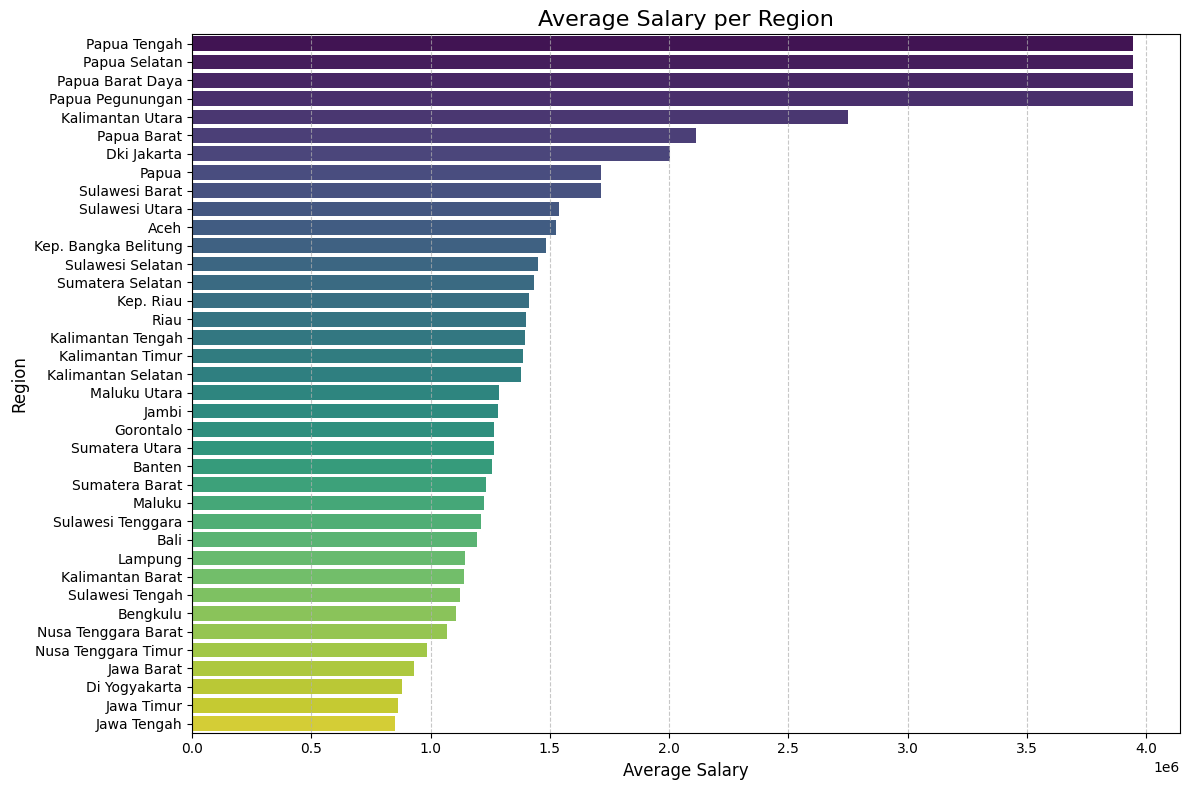

In [ ]:
# Average salary per region visualization
plt.figure(figsize=(12, 8))
sns.barplot(x=region_salary.values, y=region_salary.index, palette="viridis")

# Adding labels and title
plt.title('Average Salary per Region', fontsize=16)
plt.xlabel('Average Salary', fontsize=12)
plt.ylabel('Region', fontsize=12)

# Improve readability with grid
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

Here, we calculate the average salary for each region and sort them in descending order. A few key observations:

1. Papua regions dominate the top spots, with the highest average salaries exceeding 3.9 million. This could be due to specific industries or policies in these regions.
2. Jakarta (Dki Jakarta) ranks high as expected, reflecting its status as the capital with a high cost of living and economic activity.
3. Jawa Tengah, Jawa Timur, and Di Yogyakarta have the lowest average salaries, indicating a disparity in income between urbanized and less-developed areas on Java island.

### Yearly Salary Trends

In [ ]:
# Yearly trends
yearly_trend = df.groupby('YEAR')['SALARY'].mean()
yearly_trend

,SALARY
YEAR,
1997,1.349630e+05
1998,1.509387e+05
1999,1.753903e+05
2000,2.165065e+05
2001,2.904871e+05
2002,3.646419e+05
2003,4.149355e+05
2004,4.573097e+05
2005,5.076968e+05


<Figure size 1000x600 with 0 Axes>

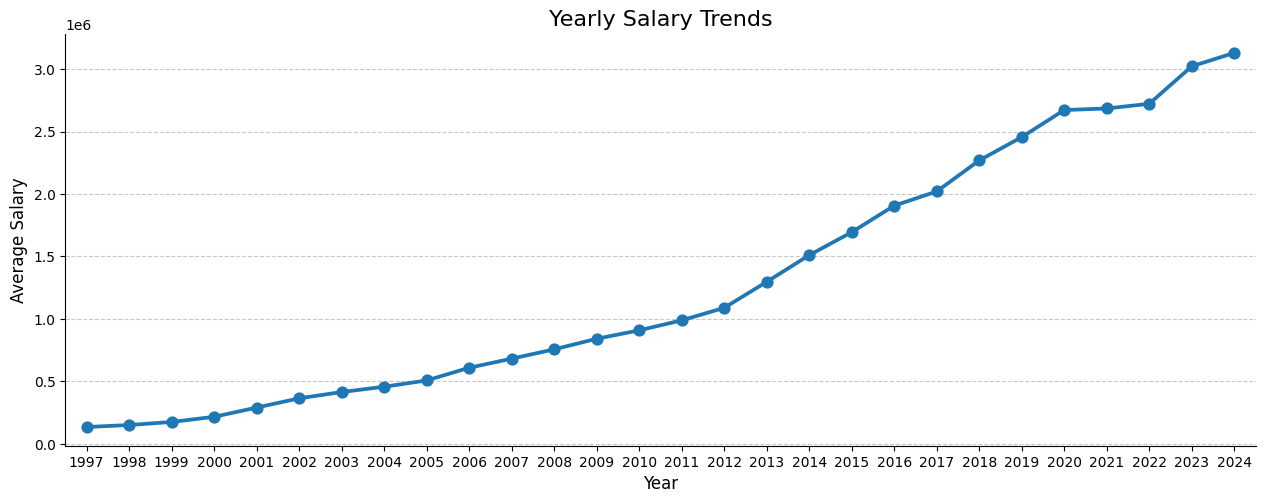

In [ ]:
# Yearly trend
plt.figure(figsize=(10, 6))
sns.catplot(x=yearly_trend.index, y=yearly_trend.values, marker='o',kind='point',aspect=2.5)

# Adding labels and title
plt.title('Yearly Salary Trends', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)

# Improve readability with grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Looking at the average salary trend from 1997 to 2024, we can observe a steady increase over the years. The salary started at around 135K in 1997 and gradually grew, especially after the early 2000s. By 2024, the average salary reached over 3 million.

Some key insights:

1. Significant growth after 2000: From around 2000 onwards, there’s a consistent upward trend, with sharp jumps seen from 2001 to 2006.
2. Slower increase post-2015: After 2015, the growth rate slows down a bit, although it remains positive.
3. 2023-2024 spike: The most significant increase happens in 2023 and 2024, where the salary jumps by over 300K, potentially reflecting higher economic activity, inflation adjustments, or specific industry booms.

### Yearly Salary Growth

In [ ]:
# Calculate salary growth of country by year

# Calculate the average salary per year for the entire country
avg = df.groupby('YEAR', as_index=False)['SALARY'].mean()

# Calculate yearly salary growth
avg['growth'] = avg['SALARY'].diff()  # Year-to-year growth
avg

,YEAR,SALARY,growth
0,1997,1.349630e+05,NaN
1,1998,1.509387e+05,15975.746714
2,1999,1.753903e+05,24451.612903
3,2000,2.165065e+05,41116.129032
4,2001,2.904871e+05,73980.645161
5,2002,3.646419e+05,74154.838710
6,2003,4.149355e+05,50293.548387
7,2004,4.573097e+05,42374.193548
8,2005,5.076968e+05,50387.129032
9,2006,6.093625e+05,101665.648094


In this step, we aim to calculate the salary growth for the entire country from year to year. First, we compute the average salary for each year and then calculate the yearly growth rate by finding the difference between the average salary of the current year and the previous year.

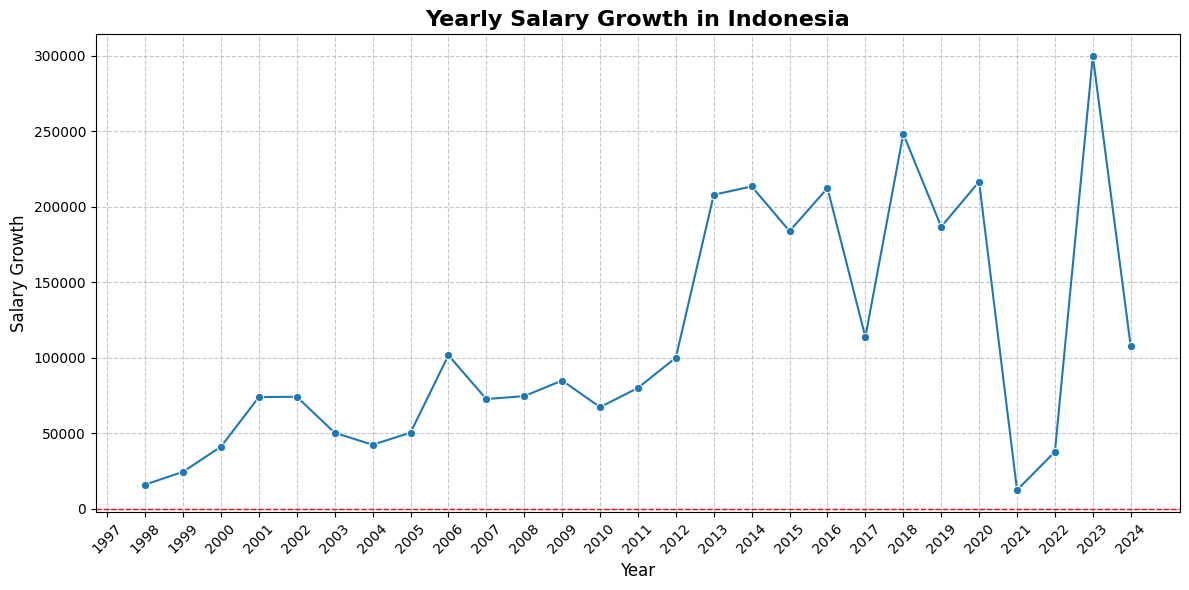

In [ ]:
# Plotting salary growth
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg, x='YEAR', y='growth', marker='o', palette="viridis")

# Adding labels and title
plt.title('Yearly Salary Growth in Indonesia', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Salary Growth', fontsize=12)

# Adding gridlines for better readability
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Highlight zero growth line
plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Customize tick parameters
# Convert 'YEAR' column to numeric
# This assumes 'YEAR' contains values that can be converted to integers
avg['YEAR'] = pd.to_numeric(avg['YEAR'])
plt.xticks(avg['YEAR'], rotation=45, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

This indicates the salary increase from one year to the next:

1. In 1998, there was a growth of approximately 16,000 compared to 1997.
2. The highest growth occurred in 2013, with an increase of about 208,000.
3. The lowest growth was in 2021, at only 12,372 compared to 2020, showing a minimal increase. Due to COVID-19.

### Top 5 Regions with Highest and Lowest Salaries

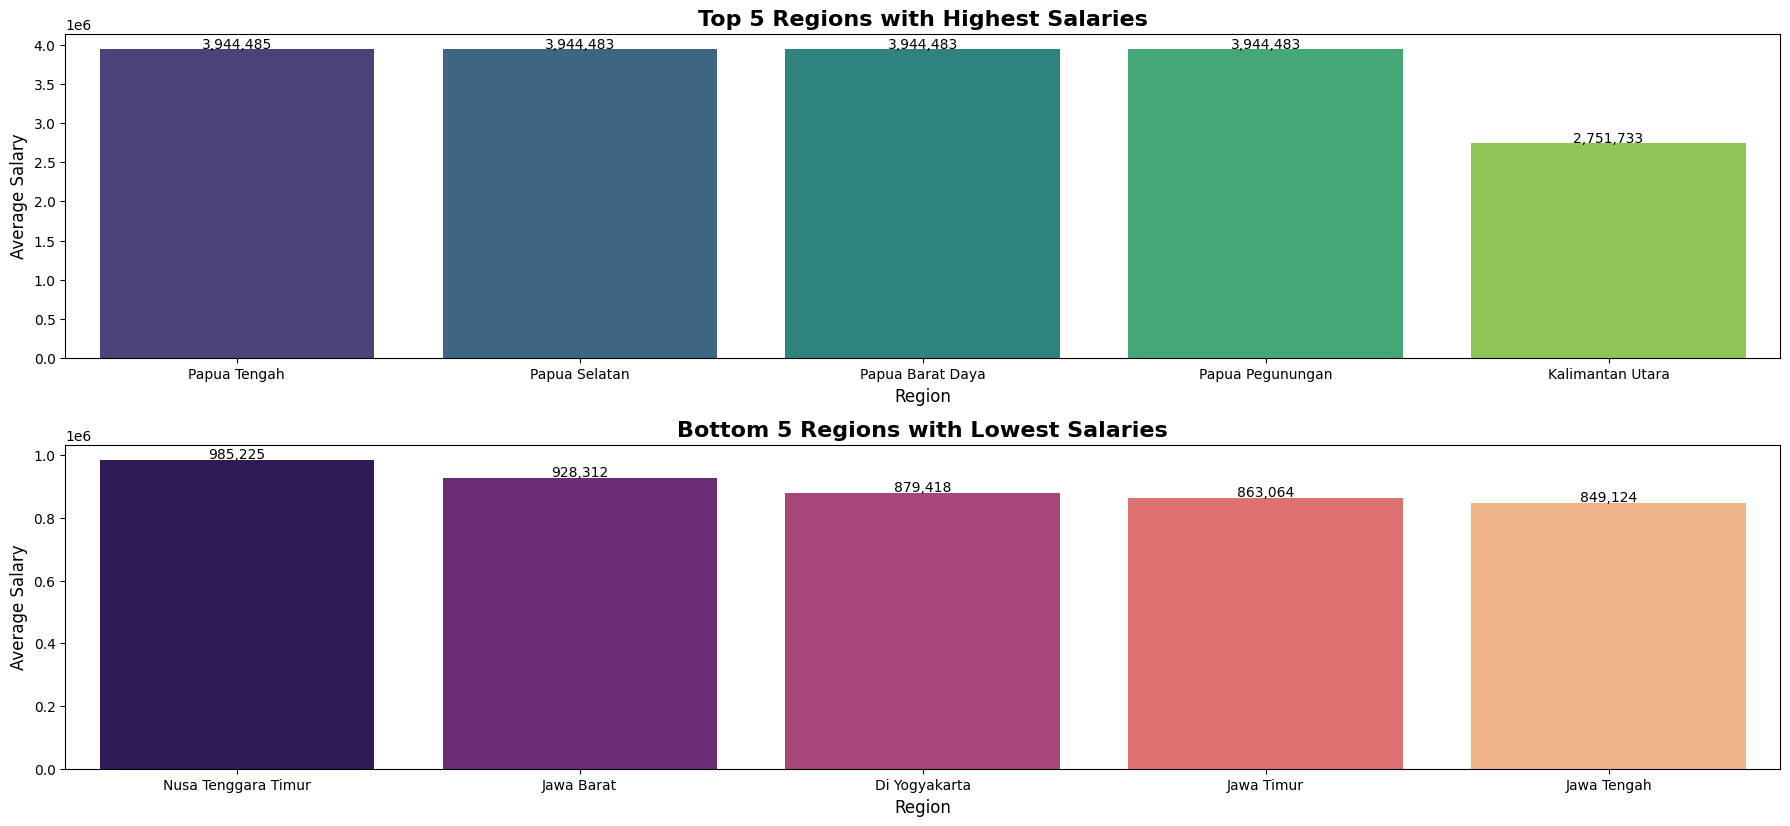

In [ ]:
# Get top 5 and bottom 5 regions
top_5_regions = region_salary.head(5)
bottom_5_regions = region_salary.tail(5)

# Full chart data
sorted_regions = region_salary.reset_index()

# Plotting
plt.figure(figsize=(18, 12))

# Subplot 1: Top 5 regions
plt.subplot(3, 1, 1)
sns.barplot(x=top_5_regions.index, y=top_5_regions.values, palette='viridis')
plt.title('Top 5 Regions with Highest Salaries', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
for i, v in enumerate(top_5_regions.values):
    plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontsize=10)

# Subplot 2: Bottom 5 regions
plt.subplot(3, 1, 2)
sns.barplot(x=bottom_5_regions.index, y=bottom_5_regions.values, palette='magma')
plt.title('Bottom 5 Regions with Lowest Salaries', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
for i, v in enumerate(bottom_5_regions.values):
    plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

From 1997 to 2015, there were province expansions, and the minimum wage (UMR) data for each year was inconsistent, which makes it irrelevant for analysis.

To obtain accurate and relevant results in the minimum wage (UMR) calculation, we will focus on data from the last 7 years, which is from 2017 to 2024. During this period, the minimum wage (UMR) figures for each year are consistent, and this will serve as the basis for the most current and relevant minimum wage analysis.

In [ ]:
# Filter data for the year above 2017
df_filtered = df[(df['YEAR'].astype(int) >= 2017)]

### Top 5 Regions with Highest and Lowest Salaries (2017-2024)

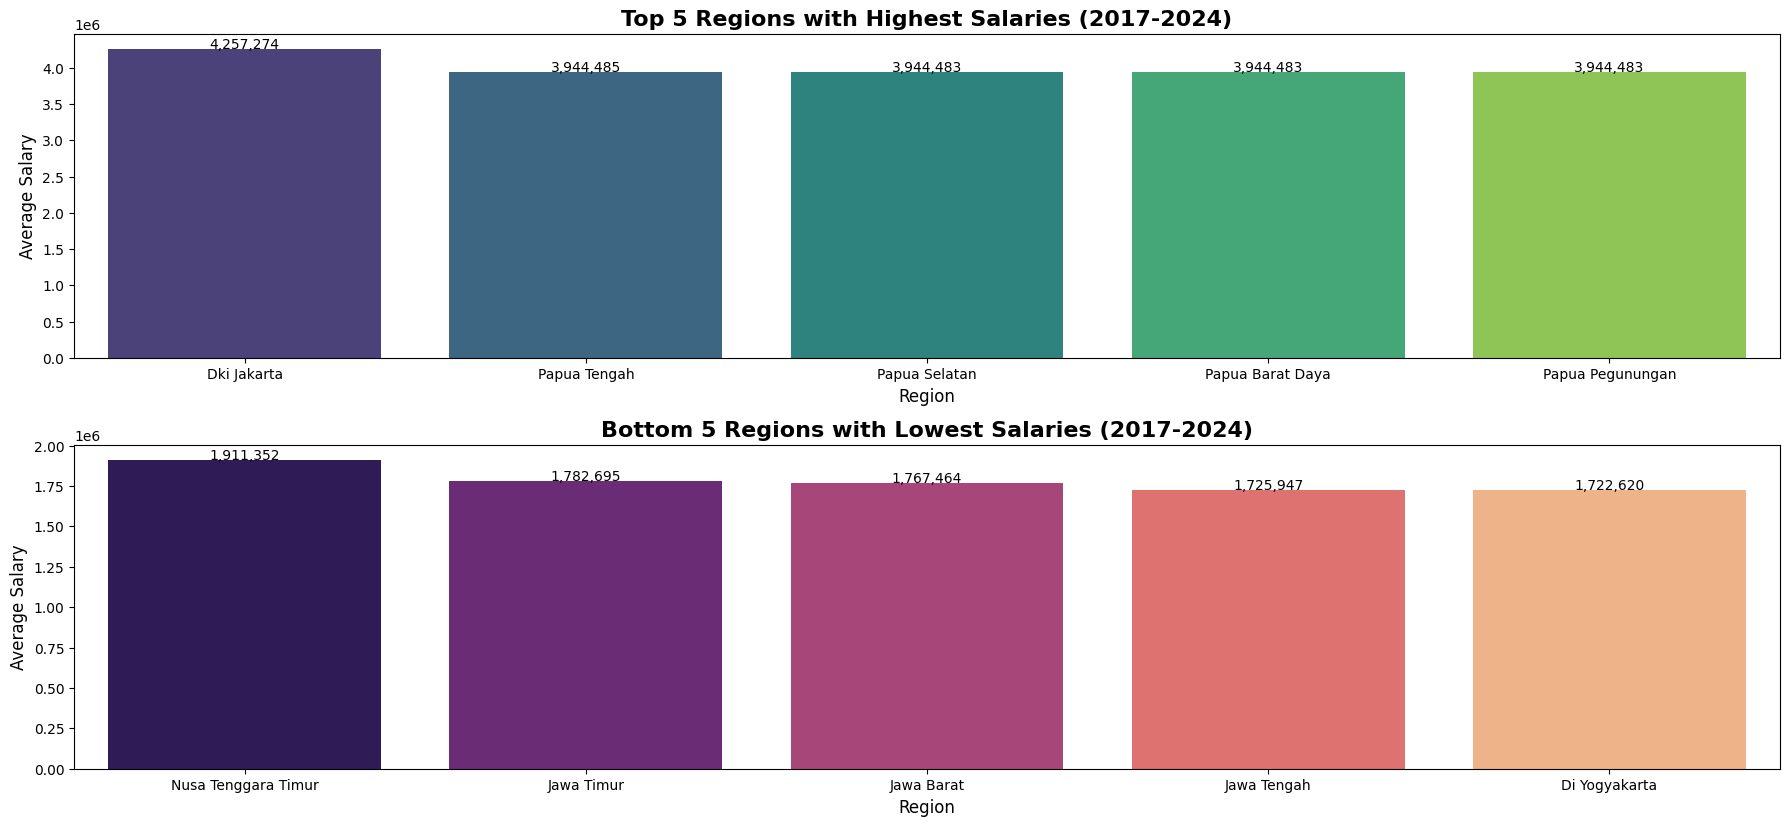

In [ ]:
# Calculate the average salary per region for 2022
region_salary_2024 = df_filtered.groupby('REGION')['SALARY'].mean().sort_values(ascending=False)

# Get top 5 and bottom 5 regions
top_5_regions_2024 = region_salary_2024.head(5)
bottom_5_regions_2024 = region_salary_2024.tail(5)

# Full chart data (sorted)
sorted_regions_2024 = region_salary_2024.reset_index()

# Plotting
plt.figure(figsize=(18, 12))

# Subplot 1: Top 5 regions for 2017-2024
plt.subplot(3, 1, 1)
sns.barplot(x=top_5_regions_2024.index, y=top_5_regions_2024.values, palette='viridis')
plt.title('Top 5 Regions with Highest Salaries (2017-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
for i, v in enumerate(top_5_regions_2024.values):
    plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontsize=10)

# Subplot 2: Bottom 5 regions for 2017-2024
plt.subplot(3, 1, 2)
sns.barplot(x=bottom_5_regions_2024.index, y=bottom_5_regions_2024.values, palette='magma')
plt.title('Bottom 5 Regions with Lowest Salaries (2017-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
for i, v in enumerate(bottom_5_regions_2024.values):
    plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()


### Salary Distribution by Region Over the Year

In [ ]:
#Salary Distribution by Region Over the Year
import plotly.express as px

fig = px.bar(
    df,
    x='REGION',
    y="SALARY",
    color="REGION",  # Color by REGION
    animation_frame="YEAR",  # Animate over the years
    range_y=[0, 4766460],  # Set the y-axis range for better scaling
    title="Salary Distribution by Region Over the Years",  # Add title
    labels={"SALARY": "Average Salary", "REGION": "Region"},  # Customize axis labels
    color_continuous_scale='Viridis',  # Use a continuous color scale
    animation_group="REGION",  # Ensure that each region animates individually
    category_orders={"REGION": sorted(df["REGION"].unique())},  # Sort regions alphabetically
)

# Update layout for better readability
fig.update_layout(
    xaxis_title="Region",
    yaxis_title="Average Salary",
    title_x=0.5,  # Center the title
    showlegend=False,  # Disable legend if not necessary
    height=600  # Adjust the figure height for better viewing
)

# Show the figure
fig.show()


In [ ]:
df

,REGION,SALARY,YEAR,ISLAND
0,Aceh,128000,1997,Sumatera
1,Aceh,147000,1998,Sumatera
2,Aceh,171000,1999,Sumatera
3,Aceh,265000,2000,Sumatera
4,Aceh,300000,2001,Sumatera
...,...,...,...,...
915,Sumatera Utara,2499423,2020,Sumatera
916,Sumatera Utara,2499423,2021,Sumatera
917,Sumatera Utara,2522609,2022,Sumatera
918,Sumatera Utara,2710493,2023,Sumatera


### Average Salary Comparison per Island in Indonesia (2017-2024)

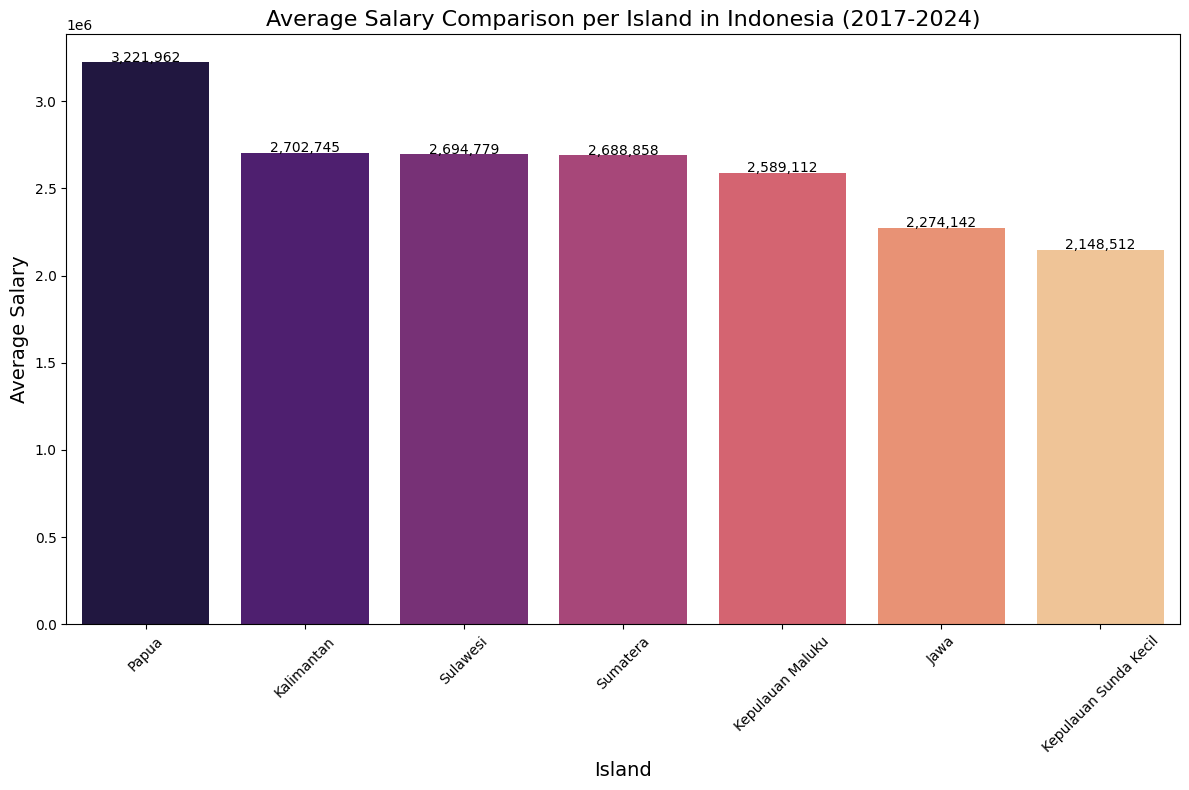

In [ ]:
# Calculate the average salary per island for the years 2017-2022
island_salary_filtered = df_filtered.groupby('ISLAND')['SALARY'].mean().sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(x=island_salary_filtered.index, y=island_salary_filtered.values, palette='magma')

# Customize the chart
plt.title('Average Salary Comparison per Island in Indonesia (2017-2024)', fontsize=16)
plt.xlabel('Island', fontsize=14)
plt.ylabel('Average Salary', fontsize=14)
plt.xticks(rotation=45)

# Add salary annotations on bars
for i, v in enumerate(island_salary_filtered.values):
    plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### Average Salary in Each Region (2017-2024)

In [ ]:
# Drop NaN values from the 'ISLAND' column
df_filtered = df_filtered.dropna(subset=['ISLAND'])

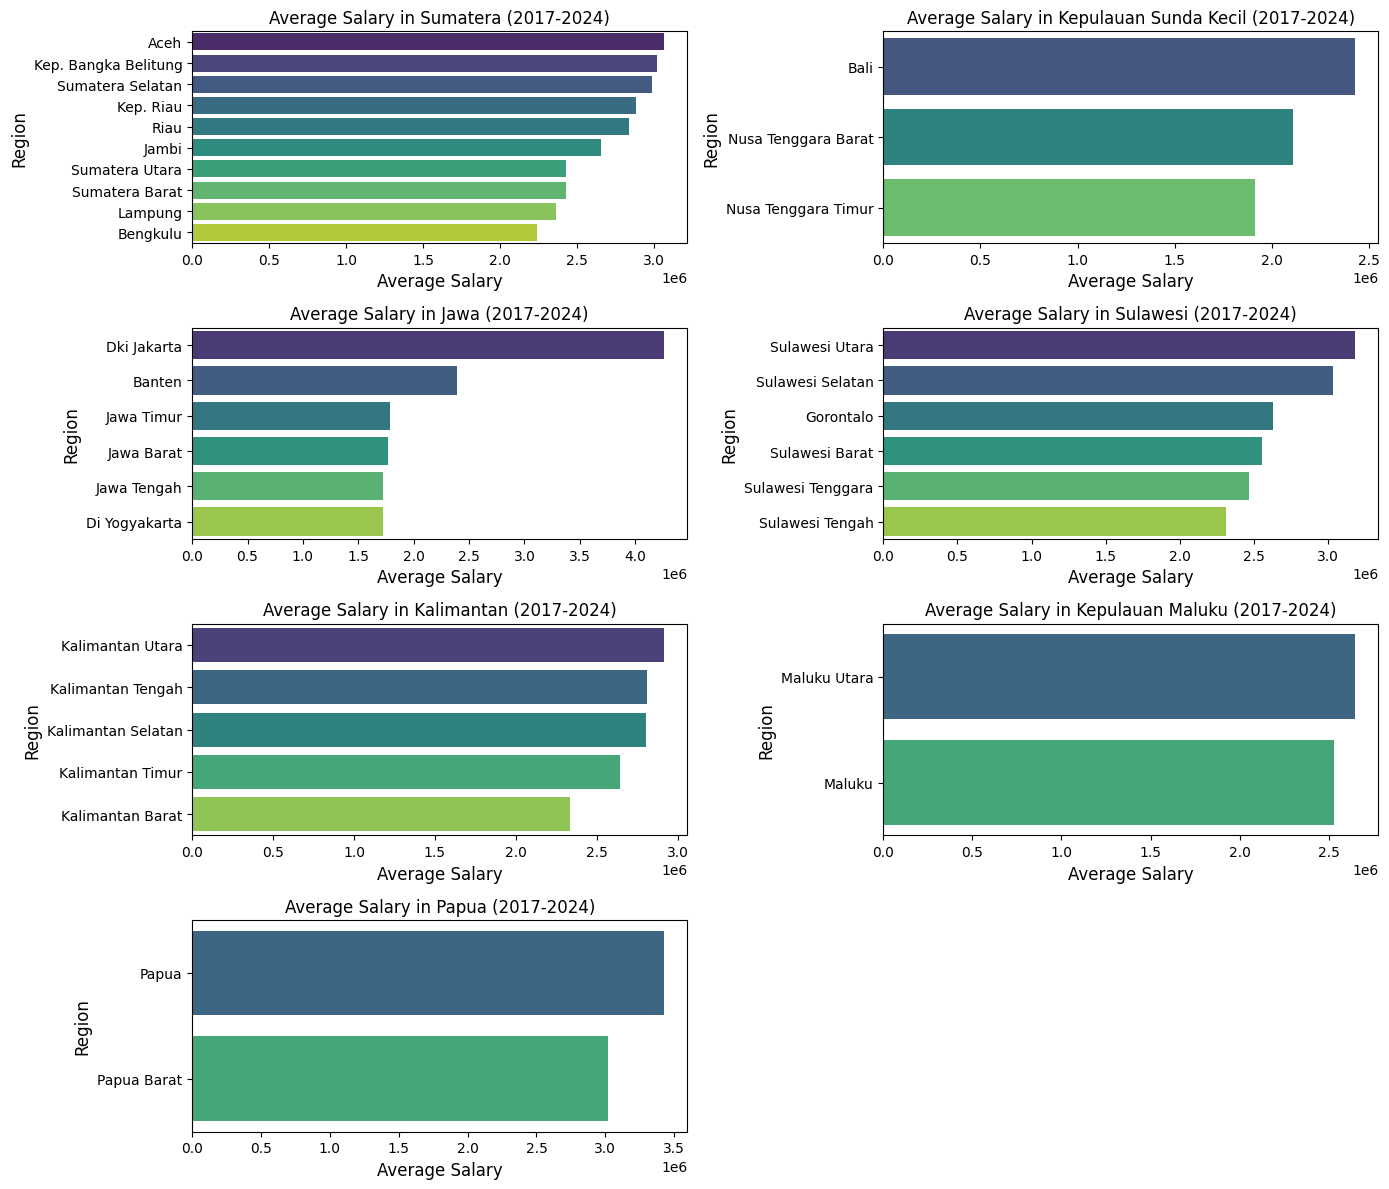

In [ ]:
# List of islands to loop through and create individual charts
islands = df_filtered['ISLAND'].unique()

# Create a plot for each island
plt.figure(figsize=(14, 12))
for i, island in enumerate(islands, 1):
    plt.subplot(4, 2, i)
    island_data = df_filtered[df_filtered['ISLAND'] == island]

    # Calculate the average salary per region and sort in ascending order
    avg_salary = island_data.groupby('REGION')['SALARY'].mean().sort_values(ascending=False)

    # Plotting the sorted average salary using horizontal barplot
    sns.barplot(y=avg_salary.index, x=avg_salary.values, palette='viridis', ci=None)

    plt.title(f'Average Salary in {island} (2017-2024)', fontsize=12)
    plt.xlabel('Average Salary', fontsize=12)
    plt.ylabel('Region', fontsize=12)

plt.tight_layout()
plt.show()

## Modelling

In this part of the analysis, we are moving on to the modeling phase. Since we have data across various regions, ideally, we'd have multiple time series for each region. However, for simplicity and to test our approach, we will start by focusing on Jakarta (Dki Jakarta) first. By selecting just this one region, we’ll be able to apply a time series forecasting model and assess how well it predicts the salary growth in Jakarta. Later, we can extend this approach to other regions if needed.

We will use ARIMA (AutoRegressive Integrated Moving Average), which is a popular statistical method for time series forecasting. It helps us model and predict future values based on past values and trends in the data. Let's start by applying it to Jakarta's salary data.

### 1. Forecast Salary for Jakarta

In [ ]:
df_jakarta = df[df["REGION"] == "Dki Jakarta"]
df_jakarta

,REGION,SALARY,YEAR,ISLAND
139,Dki Jakarta,172500,1997,Jawa
140,Dki Jakarta,198500,1998,Jawa
141,Dki Jakarta,231000,1999,Jawa
142,Dki Jakarta,286000,2000,Jawa
143,Dki Jakarta,426300,2001,Jawa
144,Dki Jakarta,591300,2002,Jawa
145,Dki Jakarta,631600,2003,Jawa
146,Dki Jakarta,671600,2004,Jawa
147,Dki Jakarta,711843,2005,Jawa
148,Dki Jakarta,819100,2006,Jawa


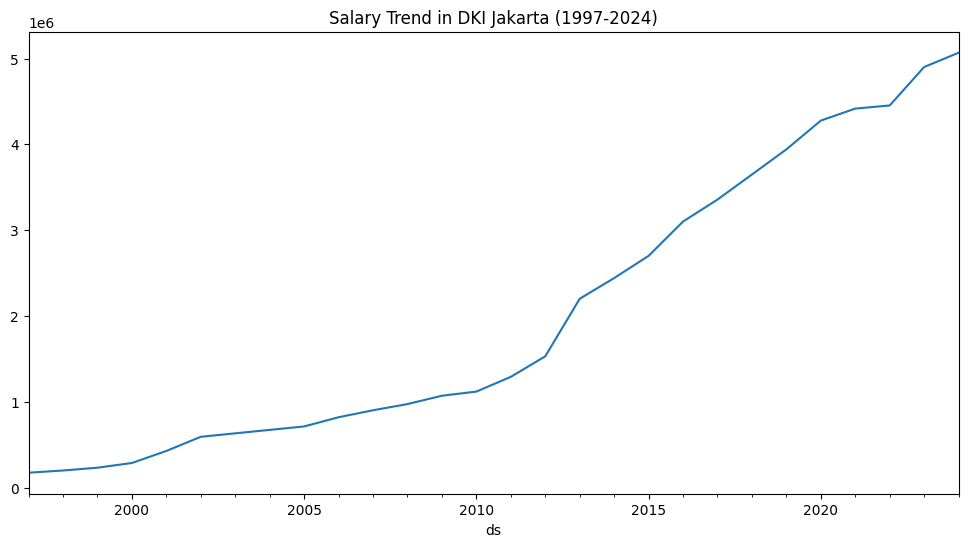

In [ ]:
# Ambil data untuk DKI Jakarta
df_jakarta = df[df['REGION'] == 'Dki Jakarta'].copy()
df_jakarta = df_jakarta.rename(columns={'YEAR': 'ds', 'SALARY': 'y'})  # Sesuaikan kolom
df_jakarta.set_index('ds', inplace=True)  # Set index ke waktu

# Plot data asli
df_jakarta['y'].plot(figsize=(12, 6), title="Salary Trend in DKI Jakarta (1997-2024)")
plt.show()

Mean Absolute Error (MAE): 93311.31071317817
Mean Squared Error (MSE): 19926969536.591503


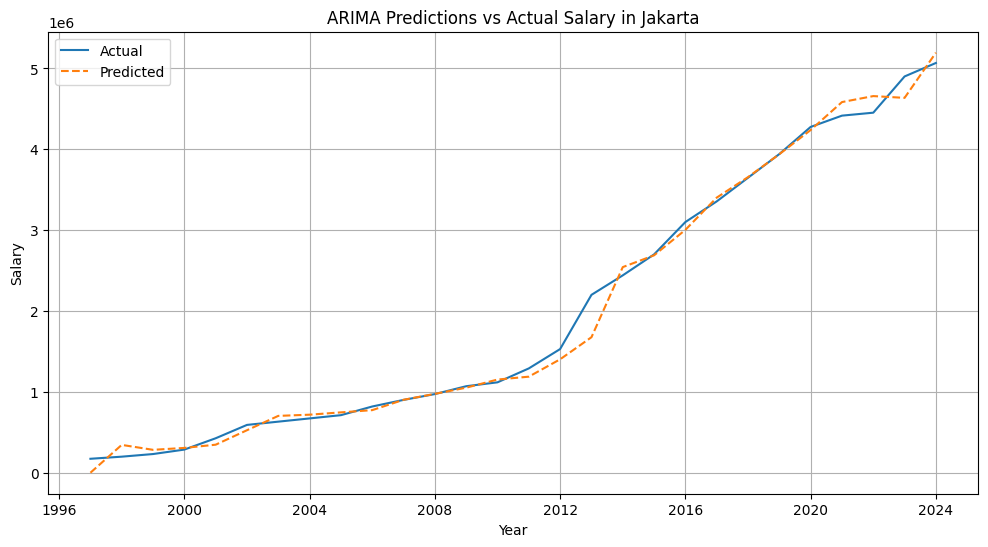

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_jakarta is already prepared as in the previous code
df_jakarta = df_jakarta.rename(columns={'YEAR': 'ds', 'SALARY': 'y'})  # Rename columns

# Ensure that 'ds' is in datetime format or string format
df_jakarta['ds'] = pd.to_datetime(df_jakarta['ds'], format='%Y')  # Convert year to datetime

# Fit the ARIMA model on the entire dataset
model = ARIMA(df_jakarta['y'], order=(2,1,2))  # Example order, adjust as needed
model_fit = model.fit()

# Make predictions on the entire dataset
predictions = model_fit.predict(start=0, end=len(df_jakarta)-1)

# Evaluate the model using Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = mean_absolute_error(df_jakarta['y'], predictions)
mse = mean_squared_error(df_jakarta['y'], predictions)

# Print the MAE and MSE
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Plot predicted vs actual with correct 'Year' labels
plt.figure(figsize=(12, 6))
plt.plot(df_jakarta['ds'], df_jakarta['y'], label='Actual')  # Using 'ds' for the x-axis
plt.plot(df_jakarta['ds'], predictions, label='Predicted', linestyle='--')  # Using 'ds' for the x-axis
plt.title('ARIMA Predictions vs Actual Salary in Jakarta')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.legend()
plt.grid(True)
plt.show()

Mean Absolute Error (MAE): 86525.06301991364
Mean Squared Error (MSE): 18992191220.616753


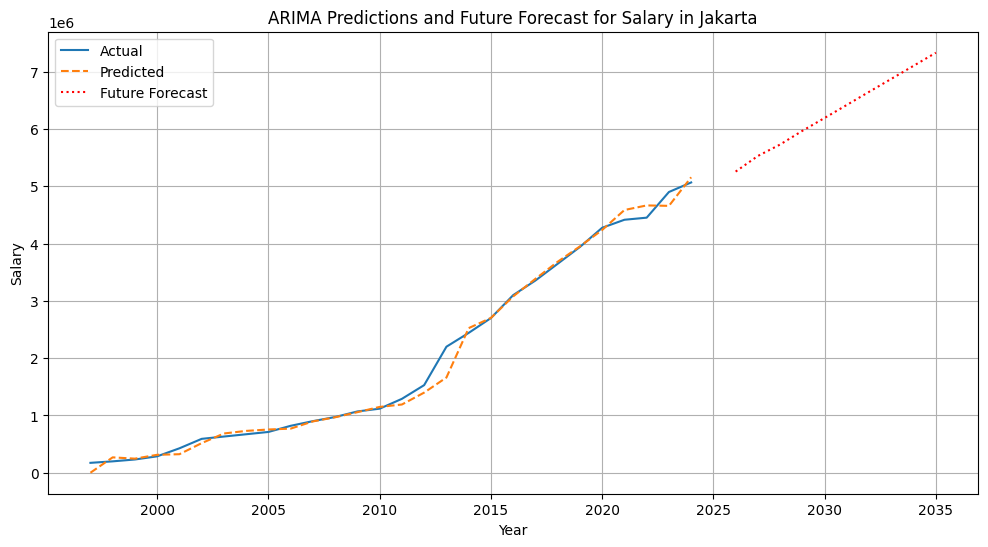

Future Forecasted Salaries:
    Year  Forecasted Salary
28  2025       5.256898e+06
29  2026       5.529757e+06
30  2027       5.729513e+06
31  2028       5.969327e+06
32  2029       6.193571e+06
33  2030       6.421159e+06
34  2031       6.649649e+06
35  2032       6.876628e+06
36  2033       7.104626e+06
37  2034       7.332147e+06


In [ ]:
# Ensure that 'ds' is in datetime format or string format
df_jakarta['ds'] = pd.to_datetime(df_jakarta['ds'], format='%Y')  # Convert year to datetime

# Fit the ARIMA model on the entire dataset
model = ARIMA(df_jakarta['y'], order=(2,2,2))  # Example order, adjust as needed
model_fit = model.fit()

# Make predictions on the entire dataset
predictions = model_fit.predict(start=0, end=len(df_jakarta)-1)

# Evaluate the model using Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = mean_absolute_error(df_jakarta['y'], predictions)
mse = mean_squared_error(df_jakarta['y'], predictions)

# Print the MAE and MSE
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Forecast future values (let's say 5 years into the future)
forecast_steps = 10  # Specify the number of periods (years) you want to forecast
future_forecast = model_fit.forecast(steps=forecast_steps)

# Generate future dates for plotting
last_date = df_jakarta['ds'].max()
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='Y')[1:]  # Skip the start date

# Plot predicted vs actual with future forecast
plt.figure(figsize=(12, 6))
plt.plot(df_jakarta['ds'], df_jakarta['y'], label='Actual')  # Using 'ds' for the x-axis (Actual)
plt.plot(df_jakarta['ds'], predictions, label='Predicted', linestyle='--')  # Predicted
plt.plot(forecast_dates, future_forecast, label='Future Forecast', linestyle=':', color='red')  # Forecast
plt.title('ARIMA Predictions and Future Forecast for Salary in Jakarta')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.legend()
plt.grid(True)
plt.show()

# Print the forecasted values with their corresponding future years
forecasted_results = pd.DataFrame({
    'Year': forecast_dates.year,  # Extract just the year part for clarity
    'Forecasted Salary': future_forecast
})

print("Future Forecasted Salaries:")
print(forecasted_results)

### 2. Forecast Salary for Jogjakarta

In [ ]:
df_jogja = df[df["REGION"] == "Di Yogyakarta"]
df_jogja

,REGION,SALARY,YEAR,ISLAND
111,Di Yogyakarta,106500,1997,Jawa
112,Di Yogyakarta,122500,1998,Jawa
113,Di Yogyakarta,130000,1999,Jawa
114,Di Yogyakarta,194500,2000,Jawa
115,Di Yogyakarta,237500,2001,Jawa
116,Di Yogyakarta,321800,2002,Jawa
117,Di Yogyakarta,360000,2003,Jawa
118,Di Yogyakarta,365000,2004,Jawa
119,Di Yogyakarta,400000,2005,Jawa
120,Di Yogyakarta,460000,2006,Jawa


Mean Absolute Error (MAE): 40306.830354942846
Mean Squared Error (MSE): 4736783035.488265


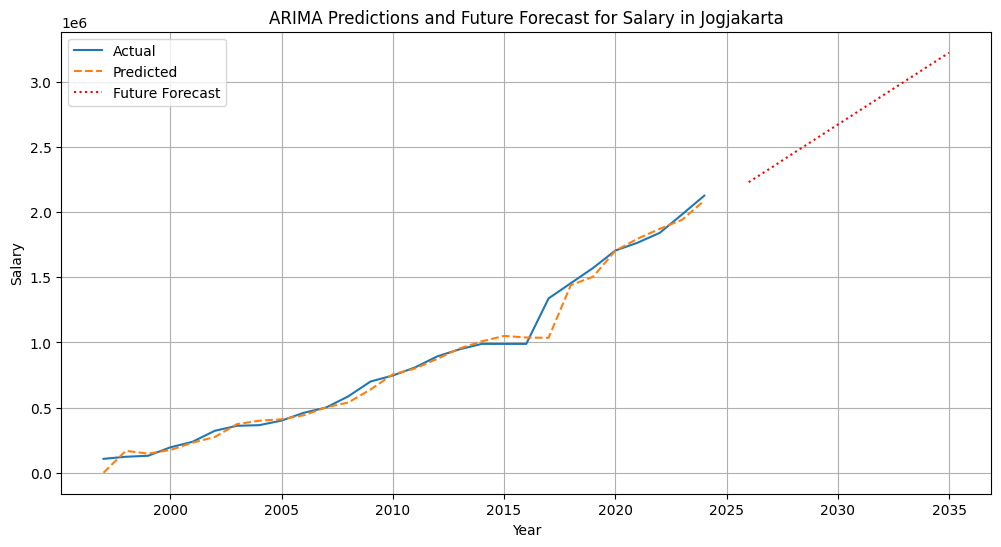

Future Forecasted Salaries:


,Year,Forecasted Salary
28,2025,2.229816e+06
29,2026,2.338636e+06
30,2027,2.450921e+06
31,2028,2.560380e+06
32,2029,2.670962e+06
33,2030,2.781328e+06
34,2031,2.891644e+06
35,2032,3.002023e+06
36,2033,3.112373e+06
37,2034,3.222730e+06


In [ ]:
# prompt: generate plot for jogja trend salary

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming df_jogja is already prepared as in the previous code
df_jogja = df[df['REGION'] == 'Di Yogyakarta'].copy()
df_jogja = df_jogja.rename(columns={'YEAR': 'ds', 'SALARY': 'y'})  # Rename columns

# Ensure that 'ds' is in datetime format or string format
df_jogja['ds'] = pd.to_datetime(df_jogja['ds'], format='%Y')  # Convert year to datetime

# Fit the ARIMA model on the entire dataset
model = ARIMA(df_jogja['y'], order=(2, 2, 2))  # Example order, adjust as needed
model_fit = model.fit()

# Make predictions on the entire dataset
predictions = model_fit.predict(start=0, end=len(df_jogja) - 1)

# Evaluate the model using Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = mean_absolute_error(df_jogja['y'], predictions)
mse = mean_squared_error(df_jogja['y'], predictions)

# Print the MAE and MSE
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Forecast future values
forecast_steps = 10  # Specify the number of periods (years) you want to forecast
future_forecast = model_fit.forecast(steps=forecast_steps)

# Generate future dates for plotting
last_date = df_jogja['ds'].max()
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='Y')[1:]  # Skip the start date

# Plot predicted vs actual with future forecast
plt.figure(figsize=(12, 6))
plt.plot(df_jogja['ds'], df_jogja['y'], label='Actual')  # Using 'ds' for the x-axis (Actual)
plt.plot(df_jogja['ds'], predictions, label='Predicted', linestyle='--')  # Predicted
plt.plot(forecast_dates, future_forecast, label='Future Forecast', linestyle=':', color='red')  # Forecast
plt.title('ARIMA Predictions and Future Forecast for Salary in Jogjakarta')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.legend()
plt.grid(True)
plt.show()

# Print the forecasted values with their corresponding future years
forecasted_results = pd.DataFrame({
    'Year': forecast_dates.year,  # Extract just the year part for clarity
    'Forecasted Salary': future_forecast
})

print("Future Forecasted Salaries:")
forecasted_results

### Forecast for Each Region in Loop

ds    0
ds    0
dtype: int64
892


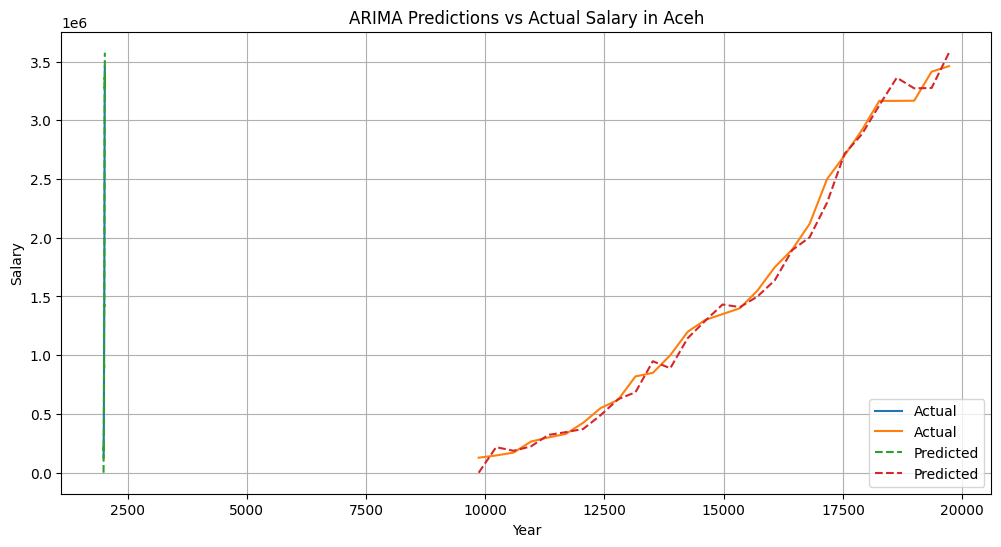

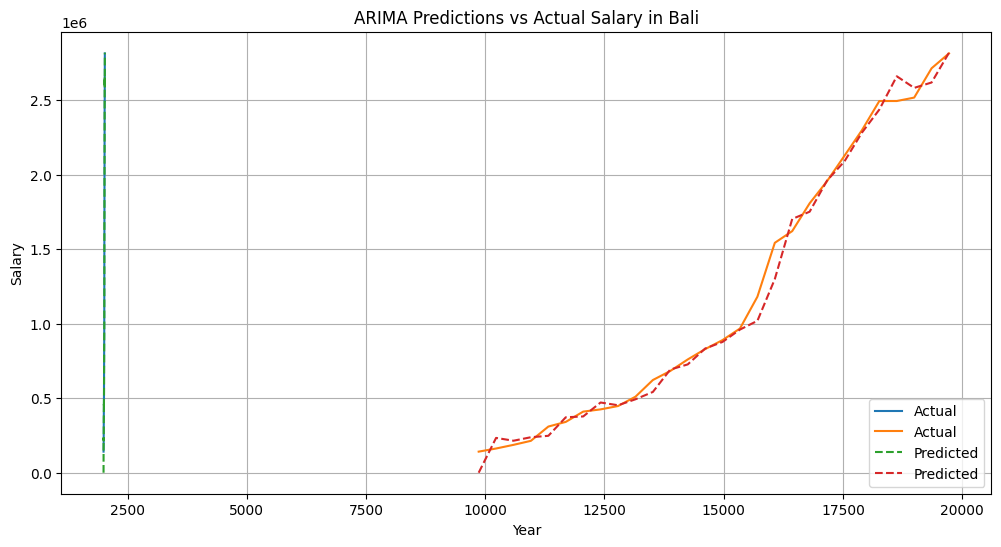

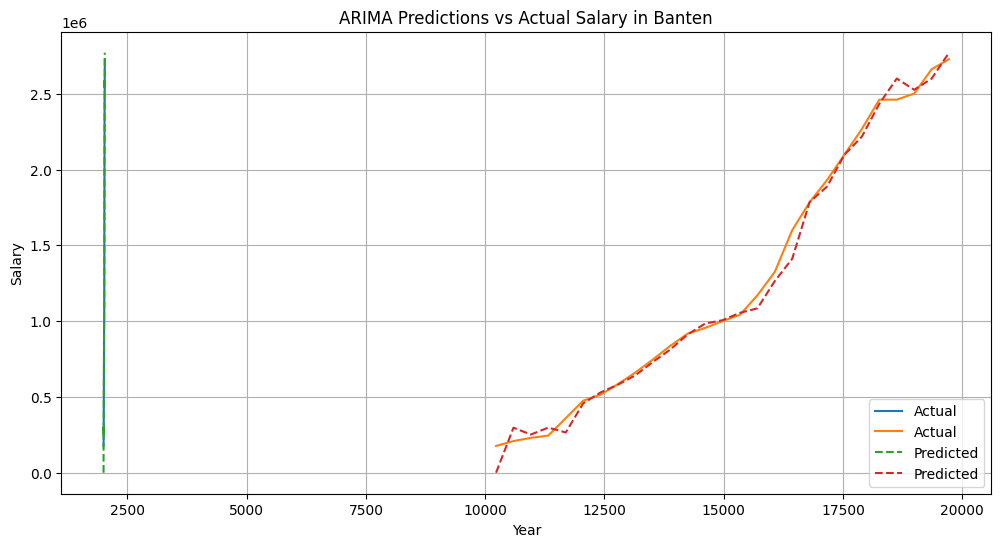

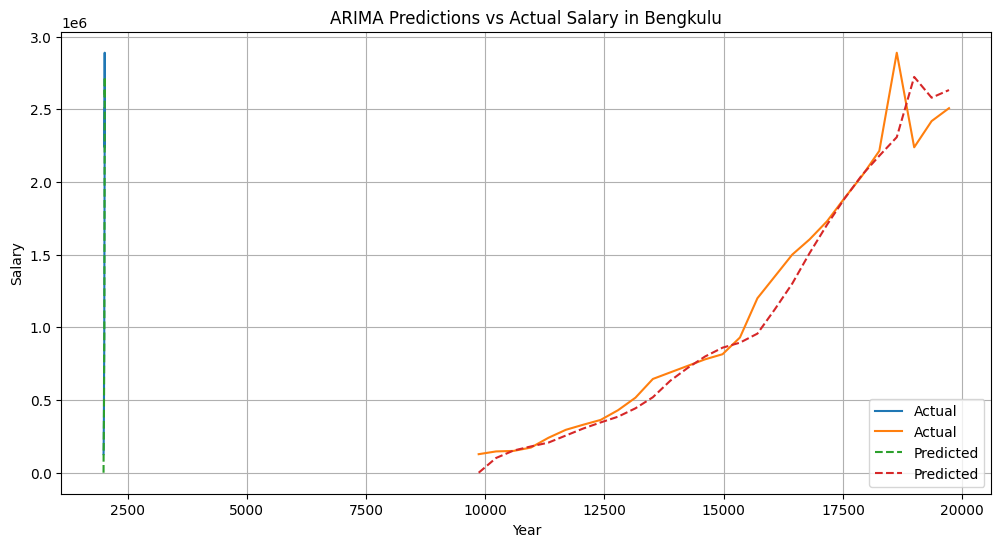

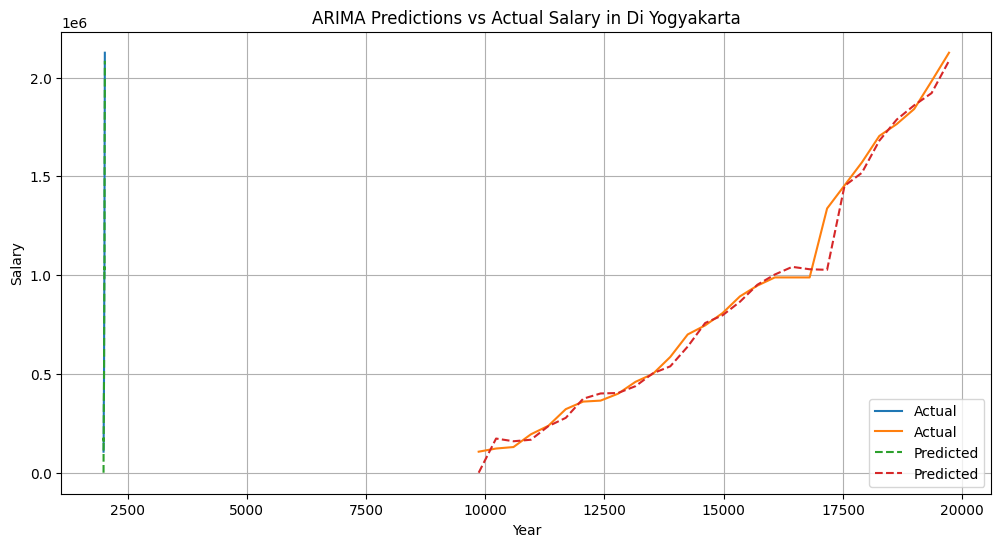

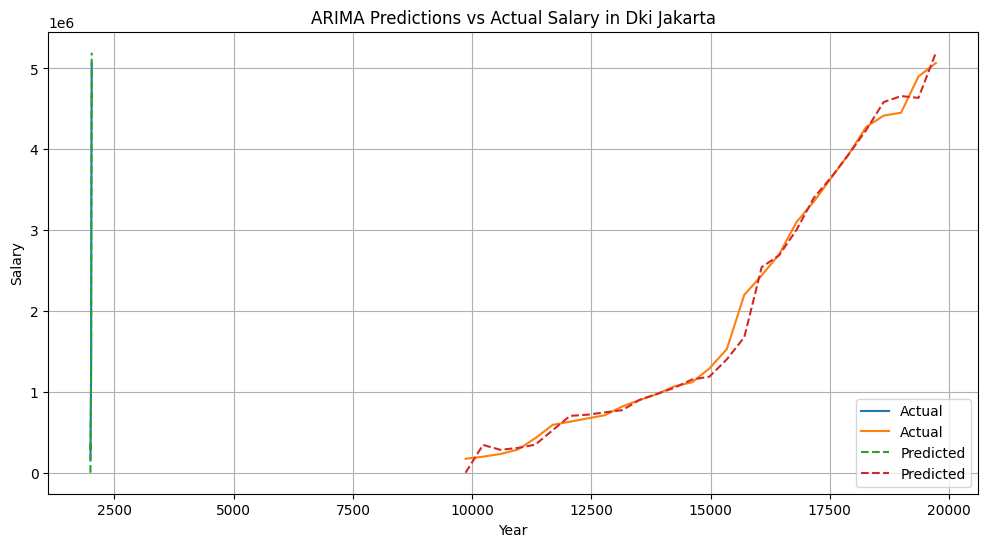

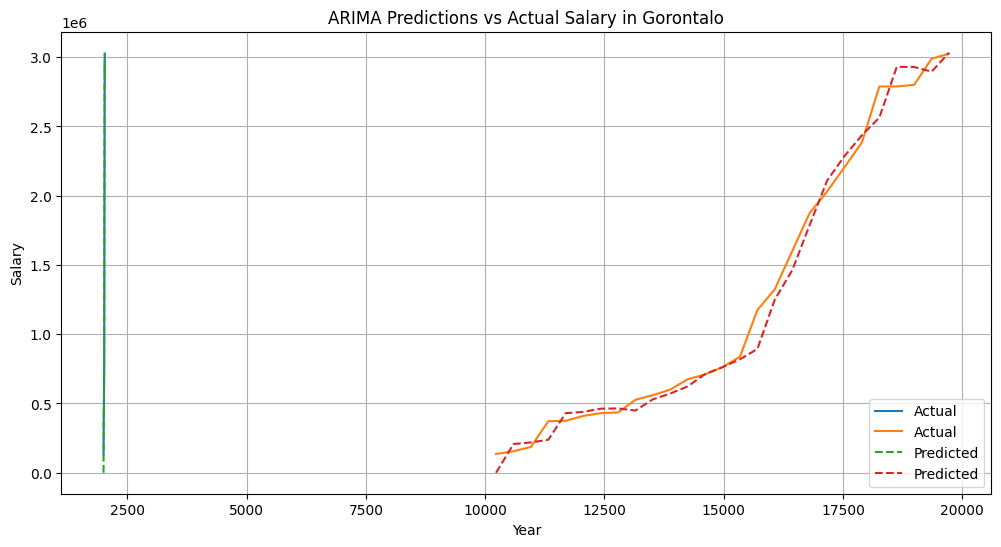

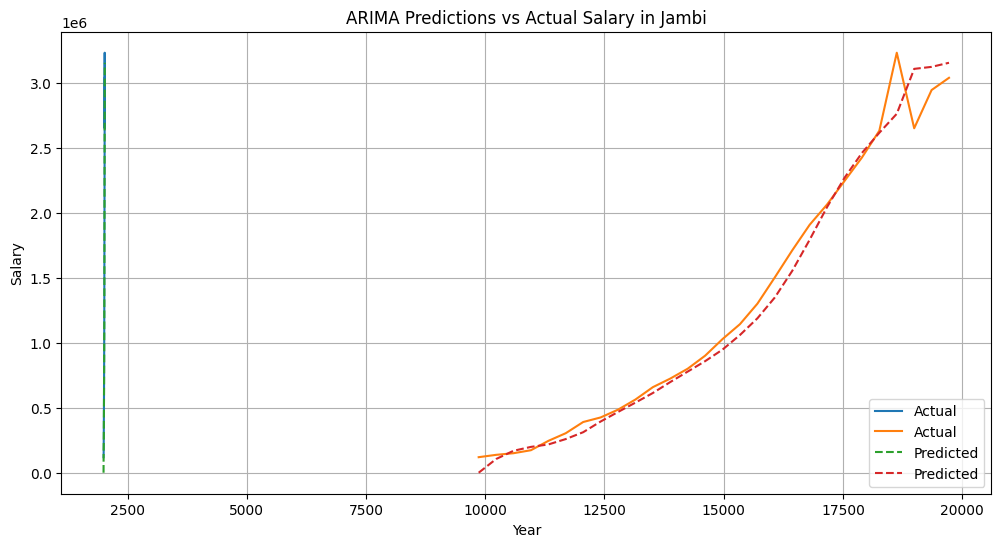

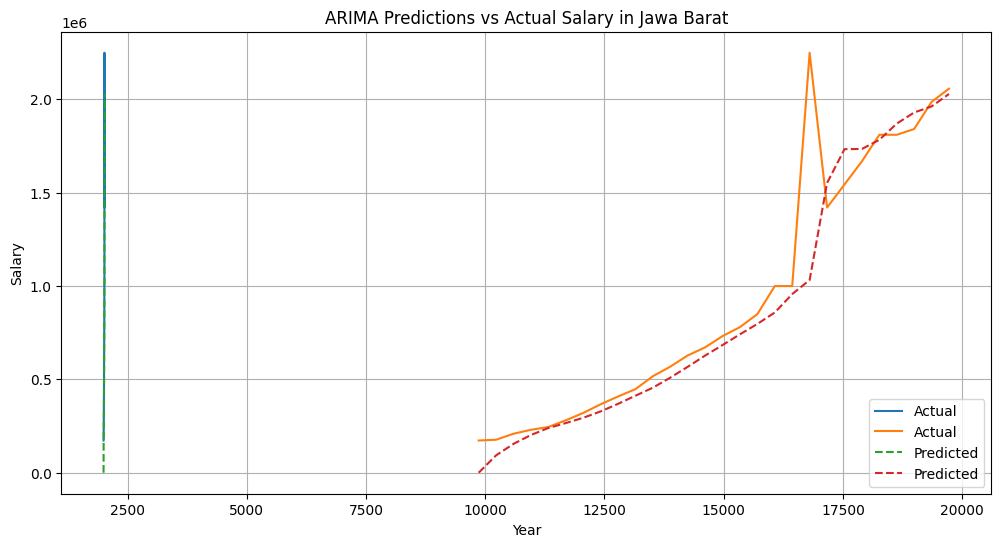

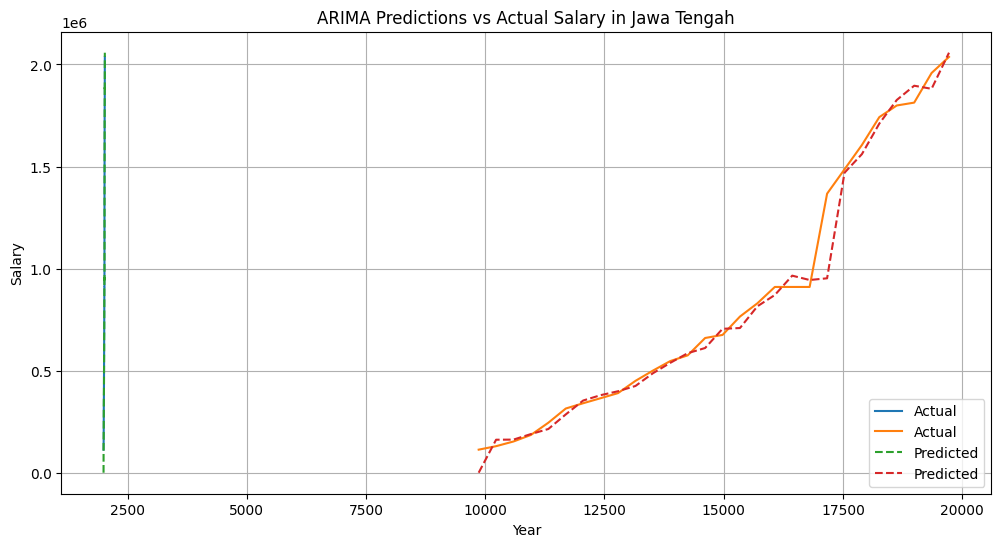

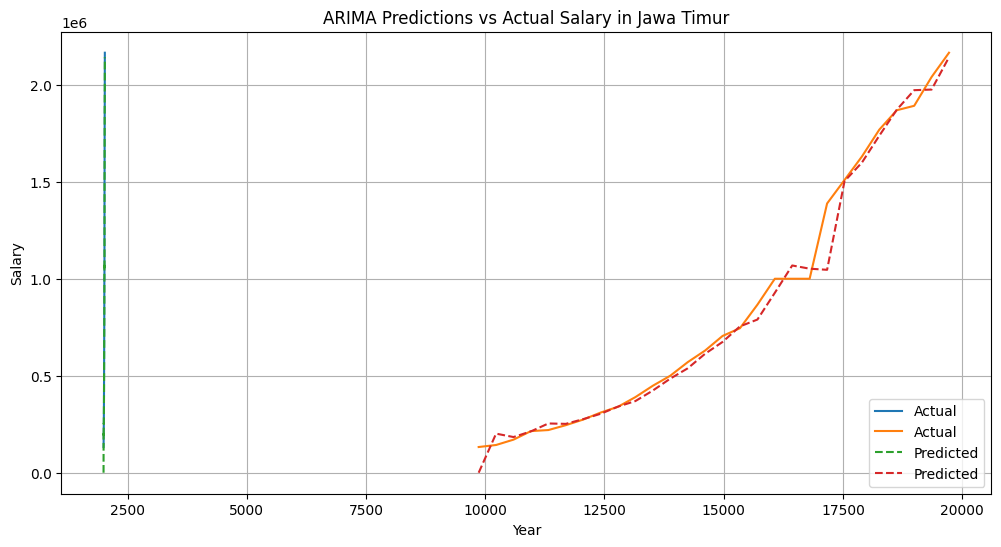

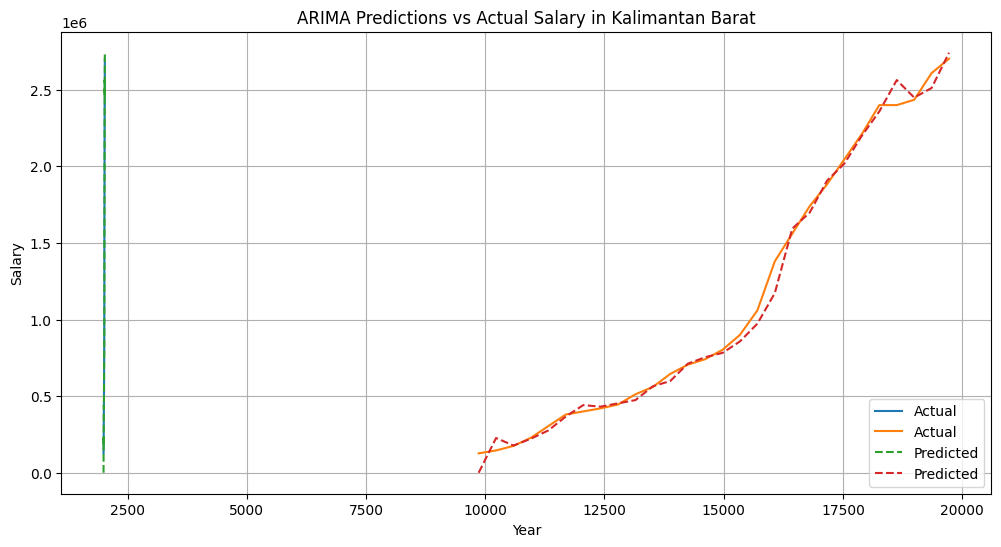

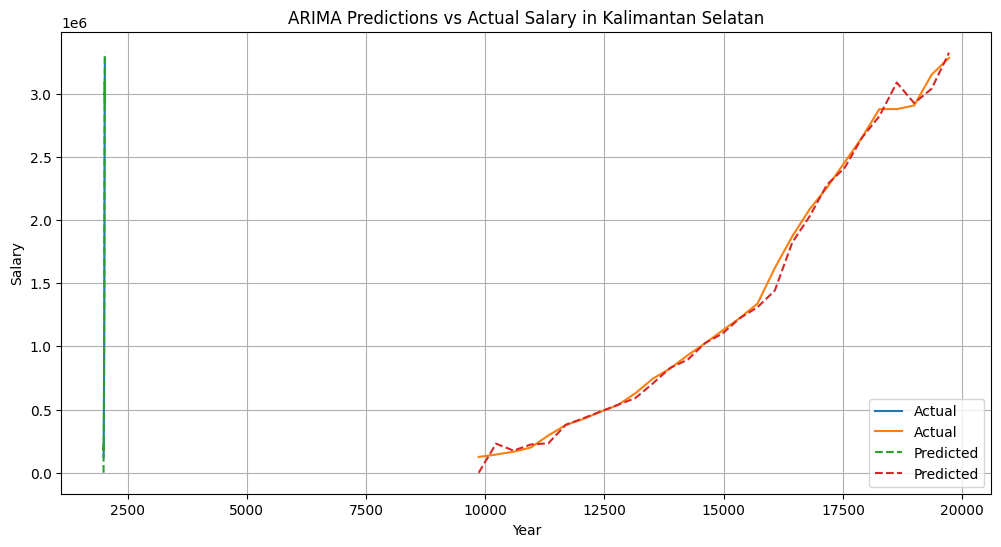

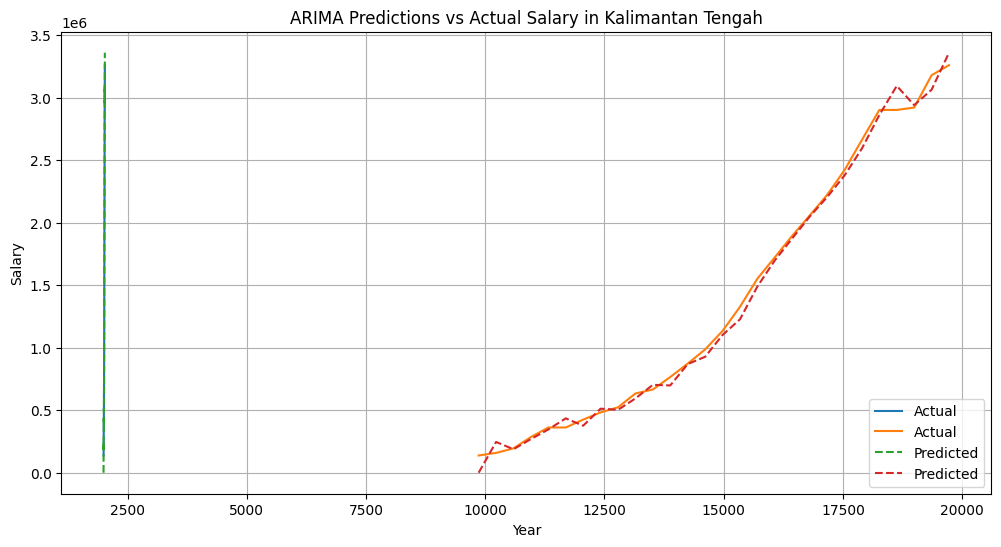

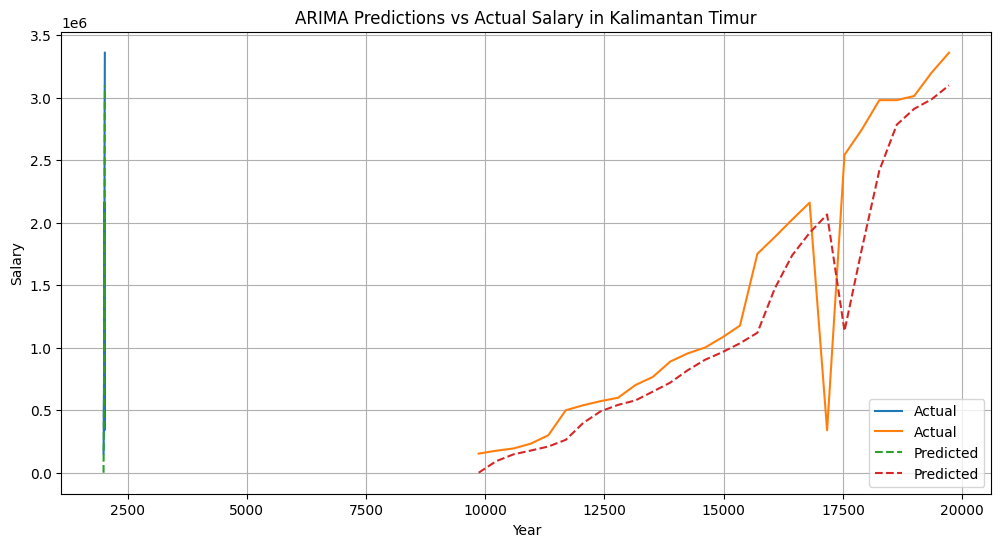

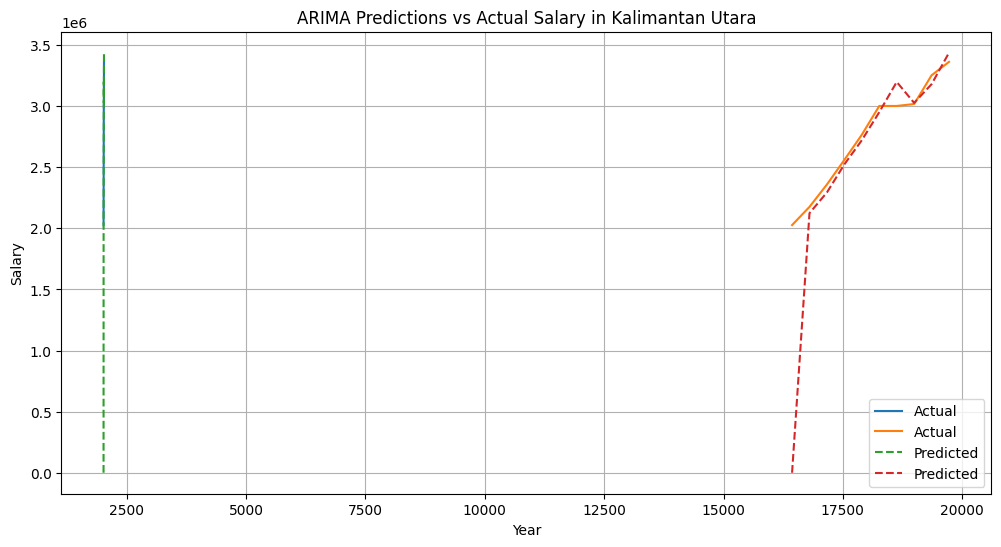

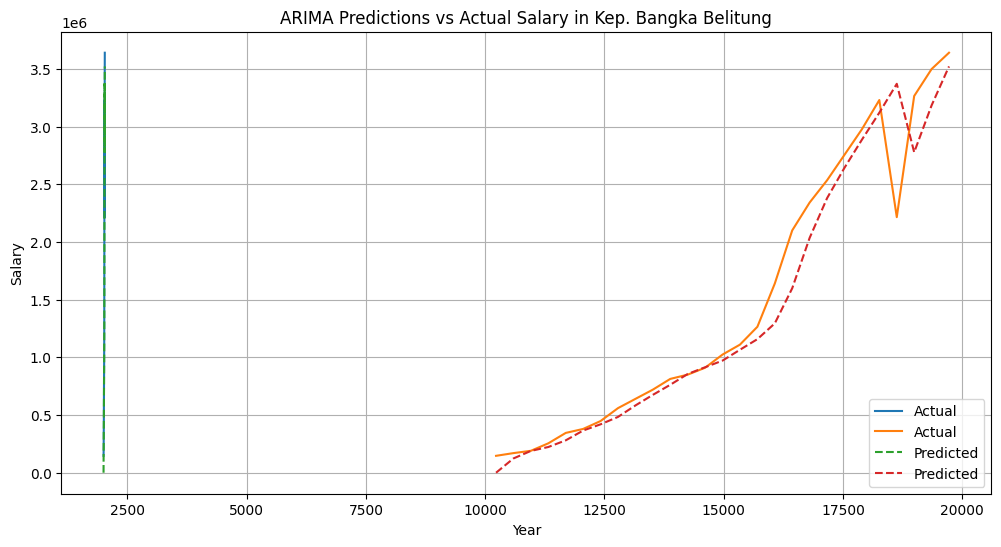

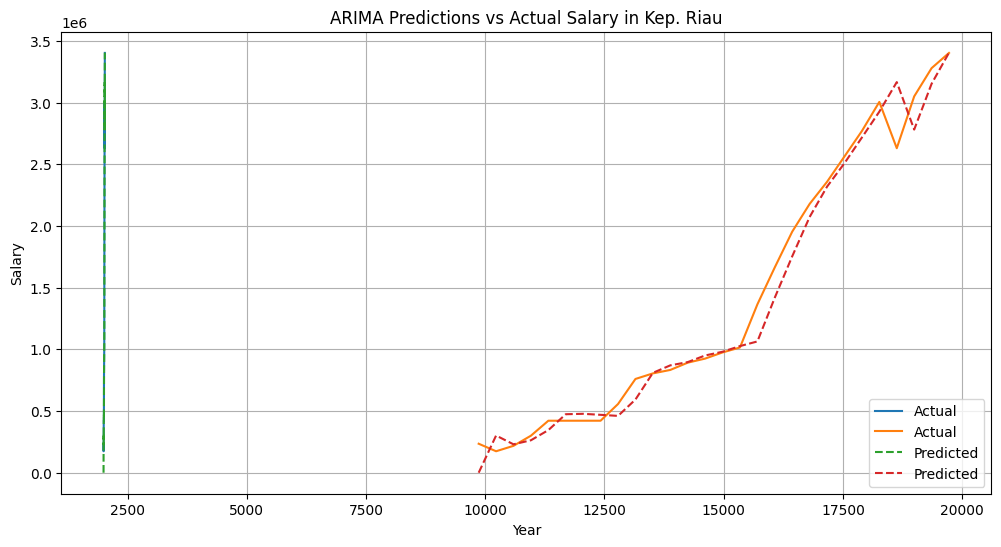

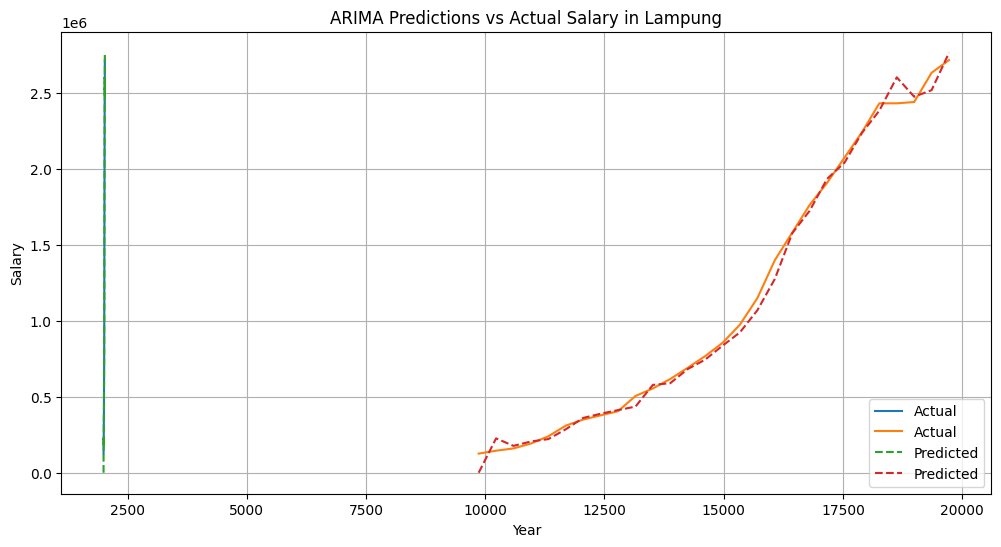

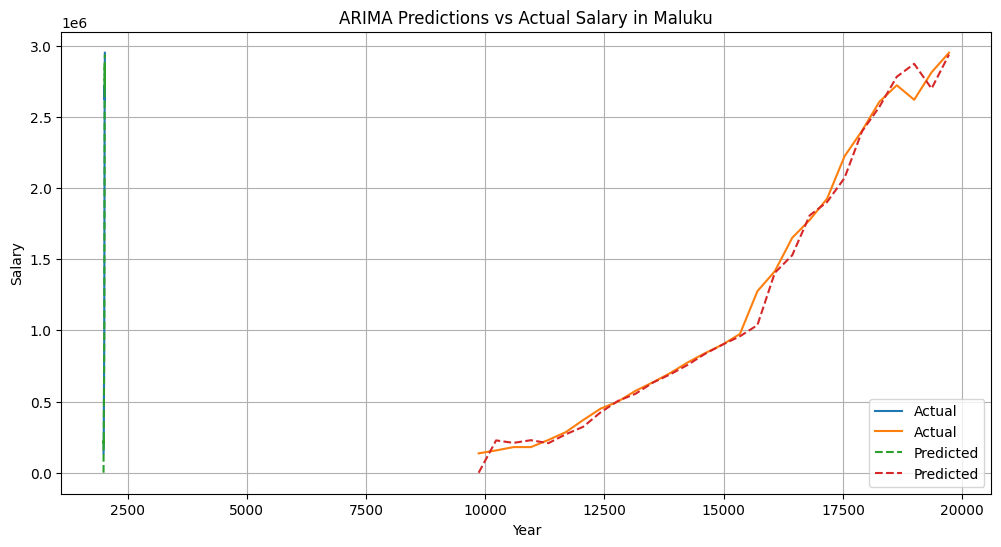

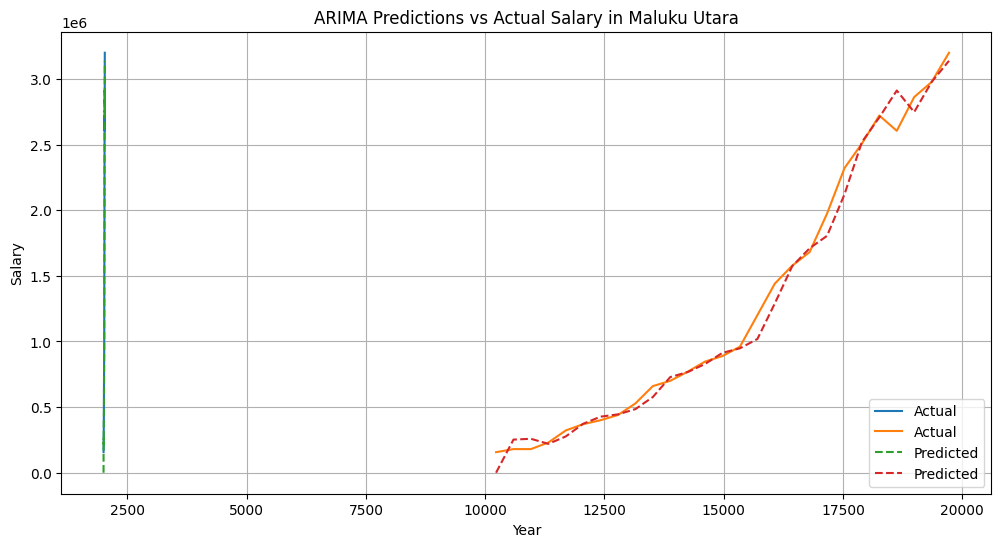

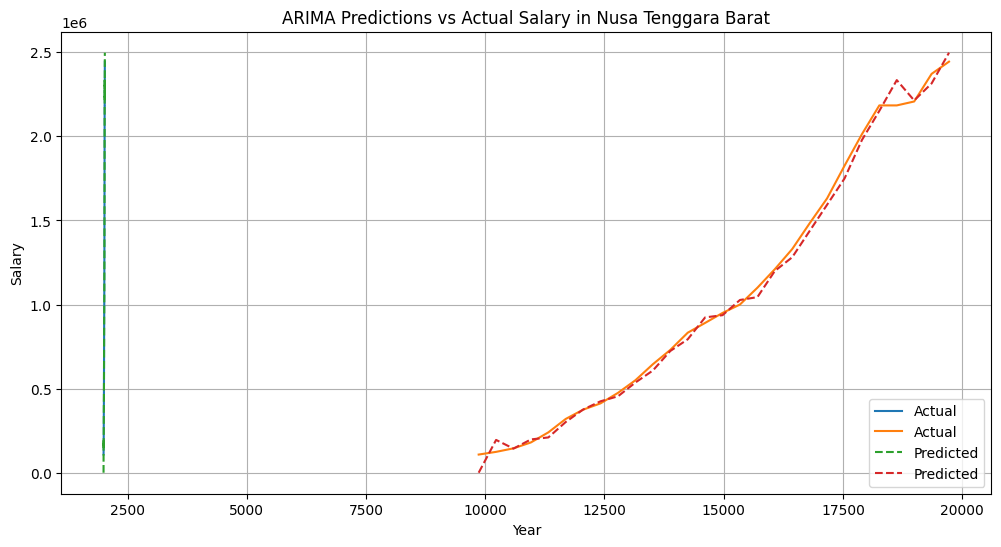

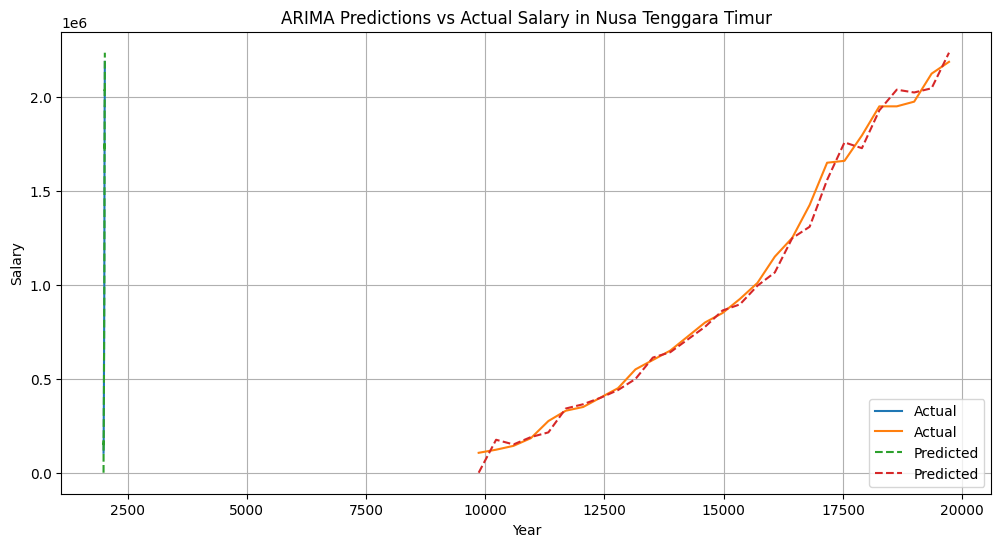

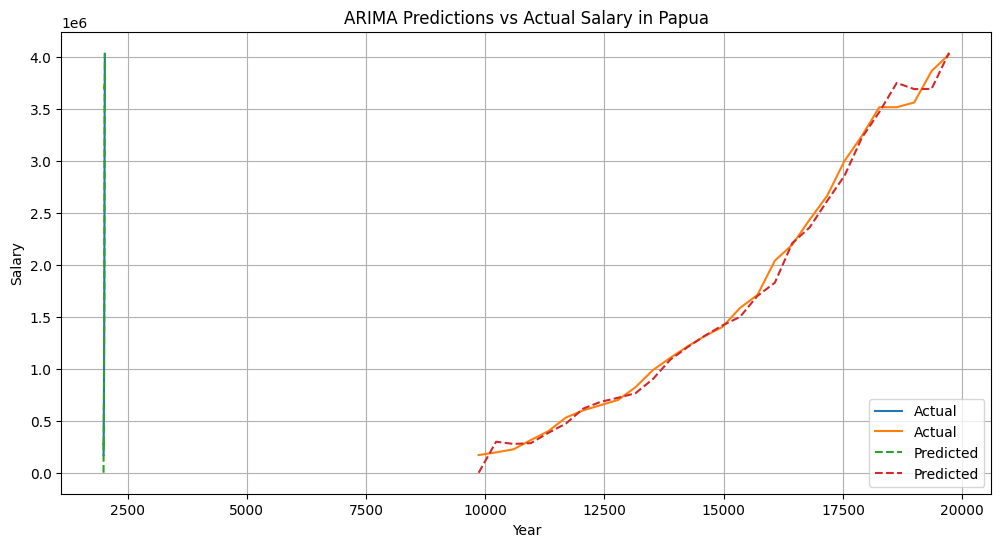

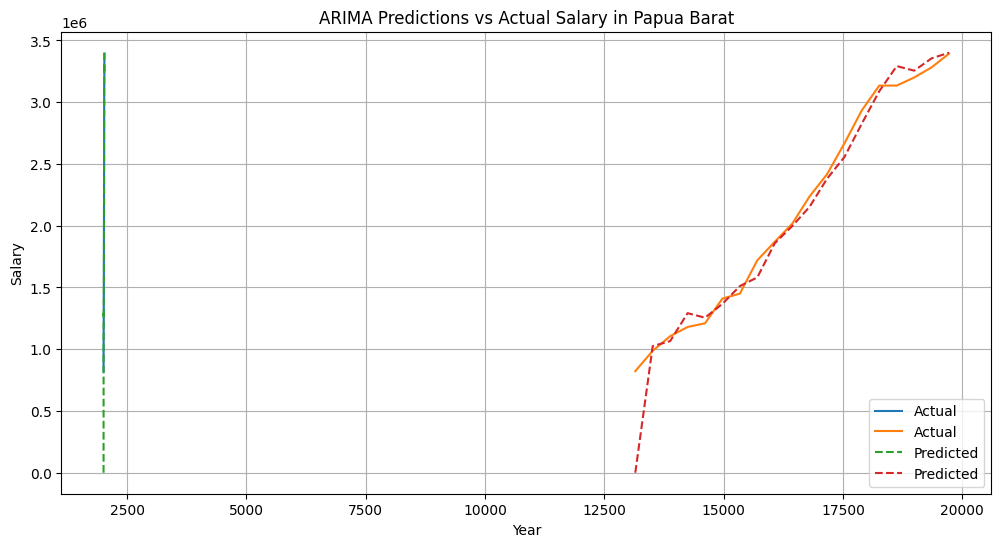

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:

# Check for missing or duplicate values in the 'ds' column (previously 'YEAR')
print(df['ds'].isna().sum())  # Check for NaN values in the 'ds' column
print(df['ds'].duplicated().sum())  # Check for duplicates in the 'ds' column

# Drop rows with missing ds values (if any)
df = df.dropna(subset=['ds'])

# Drop duplicate rows if necessary
df = df.drop_duplicates(subset=['REGION', 'ds'])  # Use 'ds' instead of 'YEAR'

# Group by region
regions = df['REGION'].unique()  # Get unique regions
results = []

# Loop through each region
for region in regions:
    # Filter data for the current region
    df_region = df[df['REGION'] == region].copy()

    # 'ds' column should already be in datetime format from previous processing
    # If not, uncomment and run the following line:
    # df_region['ds'] = pd.to_datetime(df_region['ds'], format='%Y')

    # Rename columns as required by ARIMA (ds for date, y for value)
    df_region = df_region.rename(columns={'SALARY': 'y'})

    # Fit the ARIMA model (you can adjust (p, d, q) as needed for each region)
    model = ARIMA(df_region['y'], order=(2, 1, 2))  # Example order, adjust as needed
    model_fit = model.fit()

    # Make predictions on the entire dataset (for simplicity, we'll predict all years in the dataset)
    predictions = model_fit.predict(start=0, end=len(df_region)-1)

    # Evaluate the model using Mean Absolute Error (MAE) and Mean Squared Error (MSE)
    mae = mean_absolute_error(df_region['y'], predictions)
    mse = mean_squared_error(df_region['y'], predictions)

    # Store the results
    results.append({
        'Region': region,
        'MAE': mae,
        'MSE': mse,
        'Predictions': predictions,
        'Actual': df_region['y']
    })

    # Plot the actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(df_region['ds'], df_region['y'], label='Actual')  # Actual salaries
    plt.plot(df_region['ds'], predictions, label='Predicted', linestyle='--')  # Predicted salaries
    plt.title(f'ARIMA Predictions vs Actual Salary in {region}')
    plt.xlabel('Year')
    plt.ylabel('Salary')
    plt.legend()
    plt.grid(True)
    plt.show()

# Optionally, you can print the MAE and MSE for each region
for result in results:
    print(f"Region: {result['Region']}")
    print(f"Mean Absolute Error (MAE): {result['MAE']}")
    print(f"Mean Squared Error (MSE): {result['MSE']}")
    print("-" * 50)

In [ ]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.7 MB/s eta 0:00:00


### Forecast in Widget

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import ipywidgets as widgets
from ipywidgets import interact

# Assuming df is your dataset with columns 'REGION', 'YEAR', 'SALARY'

# Clean the data
df = df.dropna(subset=['ds'])  # Remove NaN values
df = df.drop_duplicates(subset=['REGION', 'ds'])  # Remove duplicate rows

# Function to run ARIMA and plot for a specific region
def analyze_region(region):
    # Filter data for the selected region
    df_region = df[df['REGION'] == region].copy()

    # Fit the ARIMA model (adjust (p, d, q) as needed)
    model = ARIMA(df_region['y'], order=(2, 1, 2))  # Example ARIMA order
    model_fit = model.fit()

    # Make predictions
    predictions = model_fit.predict(start=0, end=len(df_region)-1)

    # Calculate MAE and MSE
    mae = mean_absolute_error(df_region['y'], predictions)
    mse = mean_squared_error(df_region['y'], predictions)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(df_region['ds'], df_region['y'], label='Actual Salary')
    plt.plot(df_region['ds'], predictions, label='Predicted Salary', linestyle='--')
    plt.title(f'ARIMA Model for {region}')
    plt.xlabel('Year')
    plt.ylabel('Salary')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print error metrics
    print(f"Region: {region}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print("-" * 50)

# Create a dropdown widget to select a region
regions = df['REGION'].unique()  # Get unique regions from the dataset
dropdown = widgets.Dropdown(
    options=regions,
    description='Region:',
    disabled=False,
)

# Create an interactive interface
interact(analyze_region, region=dropdown)

interactive(children=(Dropdown(description='Region:', options=('Aceh', 'Bali', 'Banten', 'Bengkulu', 'Di Yogya…

<function __main__.analyze_region(region)>